In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import seaborn as sns


import plotly.graph_objs as go
import plotly.offline as py
from plotly.offline import iplot, plot


from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split


from sklearn import linear_model

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.feature_selection import SelectFromModel

import lightgbm as lgb
from sklearn.decomposition import PCA

import xgboost as xgboost
from xgboost import plot_importance

from xgboost import XGBClassifier
from xgboost import XGBRegressor

import lightgbm as lgb
from sklearn.model_selection import GridSearchCV


# modelling
from scipy import stats
from sklearn.model_selection import GridSearchCV, RepeatedKFold, cross_val_score,cross_val_predict,KFold
from sklearn.metrics import make_scorer,mean_squared_error
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.svm import LinearSVR, SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor,AdaBoostRegressor
from sklearn.preprocessing import PolynomialFeatures,MinMaxScaler,StandardScaler


def MAPE(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return (np.abs((y_true - y_pred) / y_true)) * 100

/Users/i513088/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:46: UserWarning:

Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_9.4.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.



In [2]:
'''
df = pd.read_csv('~/OneDrive - SAP SE/1 Projects/160629_PipelineForecasting/GIT/forXin/LicensesDaily2.csv', 
                 sep = ';',
                decimal = ',')
'''

'''df = pd.read_csv('/Users/i513088/Desktop/Final-model/LicensesDaily2.csv',
                 sep = ';',
                decimal = ',')'''

df = pd.read_csv('/Users/i513088/Desktop/Final-model/LicensesDaily3.csv',
                 sep = ';',
                decimal = ',')

In [3]:
df.GLOBAL_01_CODE.unique()

array([nan, 'AP', 'EMEACLOT', 'EMNORTH', 'EMSOUTH', 'GCN', 'GEOOTH', 'LA',
       'MEE', 'NOAM', 'Global', 'GEOBND', 'IFRSADJ'], dtype=object)

In [4]:
df_subset = df.loc[(df['GLOBAL_01_CODE'] == "AP") 
                   | (df['GLOBAL_01_CODE'] == "EMNORTH")
                    | (df['GLOBAL_01_CODE'] == "EMSOUTH")
                    | (df['GLOBAL_01_CODE'] == "GCN")
                    | (df['GLOBAL_01_CODE'] == "LA")
                    | (df['GLOBAL_01_CODE'] == "MEE")
                    | (df['GLOBAL_01_CODE'] == "NOAM"), :]

In [5]:
df_subset.head(1)

,SnapDate,CLOSING_QUARTER_ACTUAL,GLOBAL_01_CODE,ESTIMATED_IN,CurrentQuarter_Commit,CurrentQuarterProbable,CurrentQuarter_Upside,CurrentQuarter_AB,CurrentQuarter_CD,CurrentQuarter_EF,...,Open_Commit,Open_Probable,Open_Upside,Count_Open_AB,Count_Open_CD,Count_Open_EF,Count_Open_Commit,Count_Open_Probable,Count_Open_Upside,VERBAL
1,2018-01-01,2018-Q1,AP,1894.276016,2212.488646,22447.021428,16689.331725,4053.109925,36800.694102,495.037772,...,6505.123048,80445.386912,297190.980957,85.0,1916.0,887.0,48.0,455.0,2385.0,99999.91


# Handling time dimensions
### calculate day in quarter
###### some quarter have different durations - I need to ensure that the last days in the quarter match when joining historic data. Missing values for the first day will then simply be filled with the subsequent day

In [6]:
days = df_subset[['SnapDate', 'CLOSING_QUARTER_ACTUAL']].drop_duplicates()

days['DayInQuarter'] = days.sort_values(['SnapDate'], ascending=[False]).groupby(['CLOSING_QUARTER_ACTUAL']).cumcount() + 1
days['DayInQuarter_asc'] = days.sort_values(['SnapDate'], ascending=[True]).groupby(['CLOSING_QUARTER_ACTUAL']).cumcount() + 1

In [7]:
df_subset = pd.merge(df_subset, days[['SnapDate', 'DayInQuarter', 'DayInQuarter_asc']], on = 'SnapDate', how = 'left')

In [8]:
df_subset.head(1)

,SnapDate,CLOSING_QUARTER_ACTUAL,GLOBAL_01_CODE,ESTIMATED_IN,CurrentQuarter_Commit,CurrentQuarterProbable,CurrentQuarter_Upside,CurrentQuarter_AB,CurrentQuarter_CD,CurrentQuarter_EF,...,Open_Upside,Count_Open_AB,Count_Open_CD,Count_Open_EF,Count_Open_Commit,Count_Open_Probable,Count_Open_Upside,VERBAL,DayInQuarter,DayInQuarter_asc
0,2018-01-01,2018-Q1,AP,1894.276016,2212.488646,22447.021428,16689.331725,4053.109925,36800.694102,495.037772,...,297190.980957,85.0,1916.0,887.0,48.0,455.0,2385.0,99999.91,90,1


### calculate index for quarter
###### having a running index for quarter will help calculate rolling snapshots

In [9]:
quarter = df_subset[['CLOSING_QUARTER_ACTUAL']].drop_duplicates()

quarter['QuarterIndex'] = quarter.sort_values(['CLOSING_QUARTER_ACTUAL'], ascending=[True]).reset_index().index

quarter['QuarterIndex'] = quarter['QuarterIndex'] + 1

In [10]:
df_subset = pd.merge(df_subset, quarter[['CLOSING_QUARTER_ACTUAL', 'QuarterIndex']], on = 'CLOSING_QUARTER_ACTUAL', how = 'left')

In [11]:
df_subset.head(1)

,SnapDate,CLOSING_QUARTER_ACTUAL,GLOBAL_01_CODE,ESTIMATED_IN,CurrentQuarter_Commit,CurrentQuarterProbable,CurrentQuarter_Upside,CurrentQuarter_AB,CurrentQuarter_CD,CurrentQuarter_EF,...,Count_Open_AB,Count_Open_CD,Count_Open_EF,Count_Open_Commit,Count_Open_Probable,Count_Open_Upside,VERBAL,DayInQuarter,DayInQuarter_asc,QuarterIndex
0,2018-01-01,2018-Q1,AP,1894.276016,2212.488646,22447.021428,16689.331725,4053.109925,36800.694102,495.037772,...,85.0,1916.0,887.0,48.0,455.0,2385.0,99999.91,90,1,1


# Fixing Data issues
###### the first two weeks of Q1 2019 contains incorrect values for budget - replacing them with values from day 15

In [12]:
BudgetFix = df_subset.loc[(df_subset['CLOSING_QUARTER_ACTUAL'] == "2019-Q1")  & (df_subset['DayInQuarter_asc'] == 15), :]
BudgetFix['BudgetFix'] = BudgetFix['BUDGET']

/Users/i513088/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [13]:
df_subset = pd.merge(df_subset, BudgetFix[['GLOBAL_01_CODE', 'QuarterIndex', 'BudgetFix']], 
                on = ['GLOBAL_01_CODE', 'QuarterIndex'], how = 'left')

df_subset.loc[(df_subset.DayInQuarter_asc < 15) & (df_subset.CLOSING_QUARTER_ACTUAL == "2019-Q1"), 'BUDGET'] = df_subset['BudgetFix']

df_subset = df_subset.drop("BudgetFix", axis=1)

## <font color='red'>Manipulate Quarter Index to "bootstrap" - swapping the holdout sample.<font>

In [14]:
df_subset.loc[df_subset.CLOSING_QUARTER_ACTUAL == '2018-Q1', 'QuarterIndex'] = 1
df_subset.loc[df_subset.CLOSING_QUARTER_ACTUAL == '2019-Q1', 'QuarterIndex'] = 5

# creation of Analytical dataset

#### Initiating dataset by selecting straightforward entries first (time dimensions, dependent variable, Estimated In, Open Pipe)

In [15]:
df_subset['DV2'] = df_subset.CurrentQuarter_Commit + df_subset.CurrentQuarterProbable + df_subset.CurrentQuarter_Upside

# Exploratory Analysis

### Opportunities with a qualification status of upside / probable show a different closing probability throughout the quarter. To account for this teh open opportunity value need to be adjusted.

In [16]:
dummy = df_subset[df_subset.QuarterIndex < 5].copy(deep=True)

dummy.loc[dummy.DayInQuarter > 90, 'DayInQuarter'] = 90

dummy = dummy[['GLOBAL_01_CODE', 'DayInQuarter', 'Count_Open_AB', 'Count_Open_CD', 'Count_Open_EF', 'Count_Open_Commit', 'Count_Open_Probable', 'Count_Open_Upside',
               'Count_AB', 'Count_CD', 'Count_EF', 'Count_Commit', 'Count_Probable', 'Count_Upside',
               'Open_Commit', 'Open_Probable', 'Open_Upside', 'CurrentQuarter_Commit', 'CurrentQuarterProbable', 'CurrentQuarter_Upside']]

dummy['FactorCommit'] = dummy['Count_Commit'] / dummy['Count_Open_Commit']
dummy['FactorProbable'] = dummy['Count_Probable'] / dummy['Count_Open_Probable']
dummy['FactorUpside'] = dummy['Count_Upside'] / dummy['Count_Open_Upside']

ClosingRates = dummy[['GLOBAL_01_CODE', 'DayInQuarter', 'FactorCommit', 'FactorProbable', 'FactorUpside']]

ClosingRates = dummy.groupby(by = ['GLOBAL_01_CODE', 'DayInQuarter']).mean().reset_index()

### <font color='red'>This step, we get the value 'OpenPipe_adj', which we used input variable 'WeightedPipe' later!!<font>

In [17]:
df_subset = pd.merge(df_subset, ClosingRates[['GLOBAL_01_CODE', 'DayInQuarter', 'FactorCommit', 'FactorProbable', 'FactorUpside']], 
                on = ['GLOBAL_01_CODE', 'DayInQuarter'], how = 'left')

df_subset['Open_Commit_adj'] = df_subset['Open_Commit'] * df_subset['FactorCommit']
df_subset['Open_Probable_adj'] = df_subset['Open_Probable'] * df_subset['FactorProbable']
df_subset['Open_Upside_adj'] = df_subset['Open_Upside'] * df_subset['FactorUpside']
df_subset['OpenPipe_adj'] = df_subset['Open_Upside_adj'] + df_subset['Open_Probable_adj'] + df_subset['Open_Commit_adj']

df_subset['OpenPipe_adj'] = df_subset['OpenPipe_adj'].astype(float)

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]
[ (2,1) x3,y3 ]  [ (2,2) x4,y4 ]



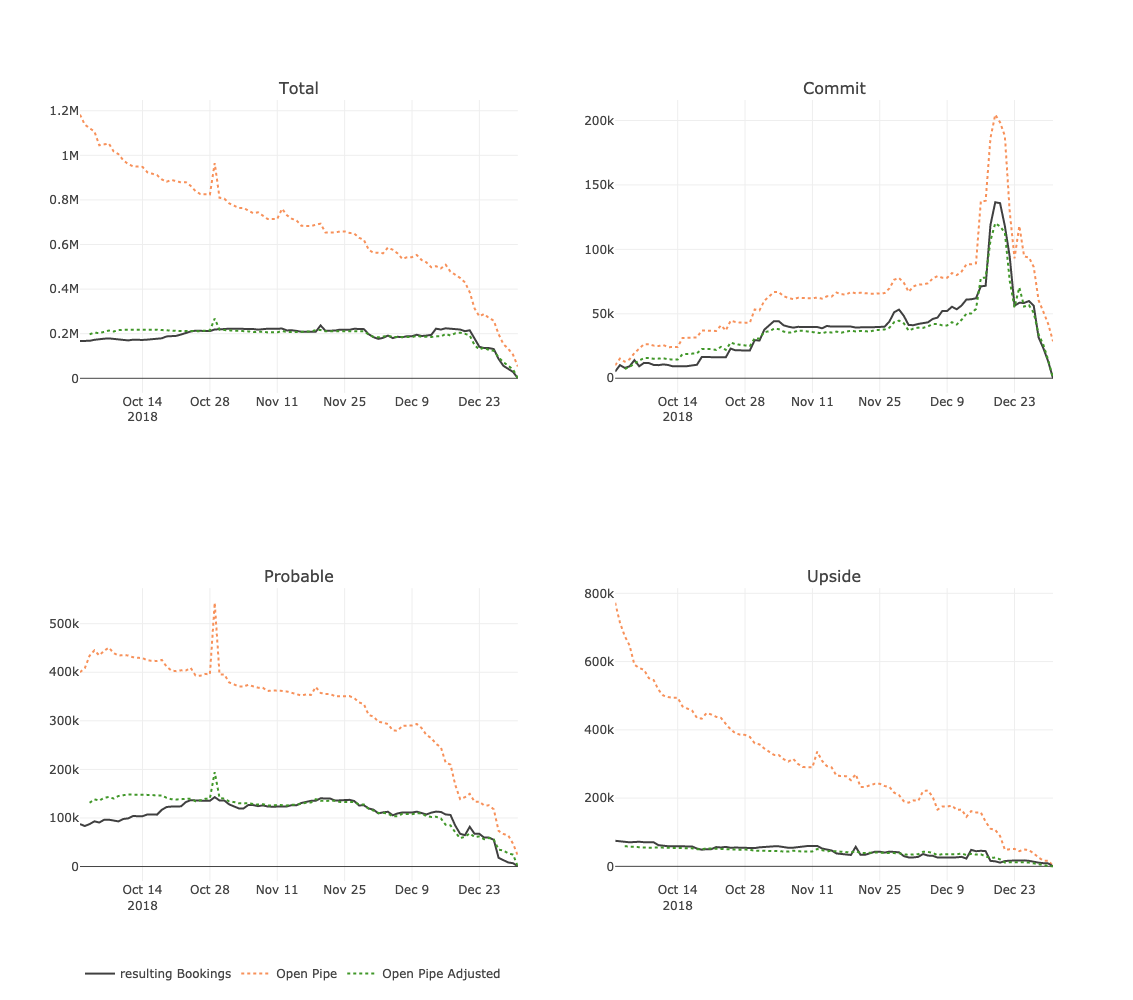

In [764]:
from plotly import tools
import plotly.offline as py
import plotly.graph_objs as go

temp = df_subset[(df_subset.GLOBAL_01_CODE == "NOAM") & (df_subset.CLOSING_QUARTER_ACTUAL == "2018-Q4")]

trace1a = go.Scatter(
    x = temp.loc[:, ['SnapDate']].values.squeeze(),
    y = temp.loc[:, ['DV2']].values.squeeze(),
    line = dict(
        color = ('rgb(64, 64, 64)'),
        width = 2),
    name = 'resulting Bookings'
)
trace1b = go.Scatter(
    x = temp.loc[:, ['SnapDate']].values.squeeze(),
    y = temp.loc[:, ['OpenPipe']].values.squeeze(),
    line = dict(
        color = ('rgb(247, 145, 90)'),
        width = 2,
        dash = 'dot'),
    name = 'Open Pipe'
)
trace1c = go.Scatter(
    x = temp.loc[:, ['SnapDate']].values.squeeze(),
    y = temp.loc[:, ['OpenPipe_adj']].values.squeeze(),
    line = dict(
        color = ('rgb(64, 151, 41)'),
        width = 2,
        dash = 'dot'),
    name = 'Open Pipe Adjusted'
)
trace2a = go.Scatter(
    x = temp.loc[:, ['SnapDate']].values.squeeze(),
    y = temp.loc[:, ['Open_Commit']].values.squeeze(),
    line = dict(
        color = ('rgb(247, 145, 90)'),
        width = 2,
        dash = 'dot'),
    name = 'Open Commit',
    showlegend=False
)
trace2c = go.Scatter(
    x = temp.loc[:, ['SnapDate']].values.squeeze(),
    y = temp.loc[:, ['Open_Commit_adj']].values.squeeze(),
    line = dict(
        color = ('rgb(64, 151, 41)'),
        width = 2,
        dash = 'dot'),
    name = 'Open Commit Adjusted',
    showlegend=False
)
trace2b = go.Scatter(
    x = temp.loc[:, ['SnapDate']].values.squeeze(),
    y = temp.loc[:, ['CurrentQuarter_Commit']].values.squeeze(),
    line = dict(
        color = ('rgb(64, 64, 64)'),
        width = 2),
    name = 'resulting Bookings',
    showlegend=False
)
trace3a = go.Scatter(
    x = temp.loc[:, ['SnapDate']].values.squeeze(),
    y = temp.loc[:, ['Open_Probable']].values.squeeze(),
    line = dict(
        color = ('rgb(247, 145, 90)'),
        width = 2,
        dash = 'dot'),
    name = 'Open Probable',
    showlegend=False
)
trace3c = go.Scatter(
    x = temp.loc[:, ['SnapDate']].values.squeeze(),
    y = temp.loc[:, ['Open_Probable_adj']].values.squeeze(),
    line = dict(
        color = ('rgb(64, 151, 41)'),
        width = 2,
        dash = 'dot'),
    name = 'Open Probable Adjusted',
    showlegend=False
)
trace3b = go.Scatter(
    x = temp.loc[:, ['SnapDate']].values.squeeze(),
    y = temp.loc[:, ['CurrentQuarterProbable']].values.squeeze(),
    line = dict(
        color = ('rgb(64, 64, 64)'),
        width = 2),
    name = 'resulting Bookings',
    showlegend=False
)
trace4a = go.Scatter(
    x = temp.loc[:, ['SnapDate']].values.squeeze(),
    y = temp.loc[:, ['Open_Upside']].values.squeeze(),
    line = dict(
        color = ('rgb(247, 145, 90)'),
        width = 2,
        dash = 'dot'),
    name = 'Open Upside',
    showlegend=False
)
trace4c = go.Scatter(
    x = temp.loc[:, ['SnapDate']].values.squeeze(),
    y = temp.loc[:, ['Open_Upside_adj']].values.squeeze(),
    line = dict(
         color = ('rgb(64, 151, 41)'),
        width = 2,
        dash = 'dot'),
    name = 'Open Upside Adjusted',
    showlegend=False
)
trace4b = go.Scatter(
    x = temp.loc[:, ['SnapDate']].values.squeeze(),
    y = temp.loc[:, ['CurrentQuarter_Upside']].values.squeeze(),
    line = dict(
        color = ('rgb(64, 64, 64)'),
        width = 2),
    name = 'resulting Bookings',
    showlegend=False
)

fig = tools.make_subplots(rows=2, cols=2, subplot_titles=('Total', 'Commit', 'Probable', 'Upside'))
fig.append_trace(trace1a, 1, 1)
fig.append_trace(trace1b, 1, 1)
fig.append_trace(trace1c, 1, 1)
fig.append_trace(trace2a, 1, 2)
fig.append_trace(trace2b, 1, 2)
fig.append_trace(trace2c, 1, 2)
fig.append_trace(trace3a, 2, 1)
fig.append_trace(trace3b, 2, 1)
fig.append_trace(trace3c, 2, 1)
fig.append_trace(trace4a, 2, 2)
fig.append_trace(trace4b, 2, 2)
fig.append_trace(trace4c, 2, 2)

fig['layout'].update(height=1000, width=1800, 
                     legend=dict(orientation="h"))

py.iplot(fig, filename='make-subplots-multiple-with-titles')

In [18]:
ad_1 = df_subset[['SnapDate', 'CLOSING_QUARTER_ACTUAL', 'GLOBAL_01_CODE', 'DayInQuarter', 'DayInQuarter_asc', 'QuarterIndex', 'BUDGET',
                  'ESTIMATED_IN', 'OpenPipe', 'Open_AB', 'Open_CD', 'Open_EF', 'Open_Commit', 'Open_Probable', 'Open_Upside', 'DV2', 'CurrentQuarter_Commit', 'CurrentQuarterProbable', 'CurrentQuarter_Upside',
                 'OpenPipe_adj', 'Open_Commit_adj', 'Open_Probable_adj', 'Open_Upside_adj']]

### Linearity based on last quarter

In [19]:
dummy0 = df_subset[['GLOBAL_01_CODE', 'DayInQuarter', 'QuarterIndex', 'ESTIMATED_IN', 'BUDGET', 'DV2']]
dummy1 = dummy0.copy(deep=True)

dummy1['QuarterIndex'] = dummy1['QuarterIndex'] + 1
dummy1['ESTIMATED_IN_tm1'] = dummy1['ESTIMATED_IN']
dummy1['DV_tm1'] = dummy1['DV2']
dummy1['BUDGET_tm1'] = dummy1['BUDGET']

dummy0 = pd.merge(dummy0, dummy1[['GLOBAL_01_CODE', 'DayInQuarter', 'QuarterIndex', 'ESTIMATED_IN_tm1', 'DV_tm1', 'BUDGET_tm1']], 
                  on = ['GLOBAL_01_CODE', 'DayInQuarter', 'QuarterIndex'], how = 'left')


In [25]:
dummy0.ESTIMATED_IN_tm1.dtype

dtype('float64')

In [26]:
dummy0.DV_tm1.dtype

dtype('float64')

In [22]:
dummy0.BUDGET_tm1

0                NaN
1                NaN
2                NaN
3                NaN
4                NaN
            ...     
3180    221872.84443
3181    111275.44468
3182     96967.93891
3183    485527.93775
3184    448021.94879
Name: BUDGET_tm1, Length: 3185, dtype: float64

In [767]:
dummy0['Linearity_EstIn_1Q'] = dummy0.DV_tm1 / dummy0.ESTIMATED_IN_tm1
dummy0['Linearity_Budget_1Q'] = dummy0.DV_tm1 / dummy0.BUDGET_tm1

In [768]:
ad_2 = pd.merge(ad_1, dummy0[['GLOBAL_01_CODE', 'DayInQuarter', 'QuarterIndex', 'Linearity_EstIn_1Q', 'Linearity_Budget_1Q']], 
                on = ['GLOBAL_01_CODE', 'DayInQuarter', 'QuarterIndex'], how = 'left')

### Linearity based on quarter - 2

In [769]:
dummy0 = df_subset[['GLOBAL_01_CODE', 'DayInQuarter', 'QuarterIndex', 'ESTIMATED_IN', 'BUDGET', 'DV2']]
dummy2 = dummy0.copy(deep=True)

dummy2['QuarterIndex'] = dummy2['QuarterIndex'] + 2
dummy2['ESTIMATED_IN_tm2'] = dummy2['ESTIMATED_IN']
dummy2['DV_tm2'] = dummy2['DV2']
dummy2['BUDGET_tm2'] = dummy2['BUDGET']

dummy0 = pd.merge(dummy0, dummy2[['GLOBAL_01_CODE', 'DayInQuarter', 'QuarterIndex', 'ESTIMATED_IN_tm2', 'DV_tm2', 'BUDGET_tm2']], 
                  on = ['GLOBAL_01_CODE', 'DayInQuarter', 'QuarterIndex'], how = 'left')

In [770]:
dummy0['Linearity_EstIn_2Q'] = dummy0.DV_tm2 / dummy0.ESTIMATED_IN_tm2
dummy0['Linearity_Budget_2Q'] = dummy0.DV_tm2 / dummy0.BUDGET_tm2

In [771]:
ad_3 = pd.merge(ad_2, dummy0[['GLOBAL_01_CODE', 'DayInQuarter', 'QuarterIndex', 'Linearity_EstIn_2Q', 'Linearity_Budget_2Q']], 
                on = ['GLOBAL_01_CODE', 'DayInQuarter', 'QuarterIndex'], how = 'left')

### Linearity based on quarter - 3

In [772]:
dummy0 = df_subset[['GLOBAL_01_CODE', 'DayInQuarter', 'QuarterIndex', 'ESTIMATED_IN', 'BUDGET', 'DV2']]
dummy3 = dummy0.copy(deep=True)

dummy3['QuarterIndex'] = dummy3['QuarterIndex'] + 3
dummy3['ESTIMATED_IN_tm3'] = dummy3['ESTIMATED_IN']
dummy3['DV_tm3'] = dummy3['DV2']
dummy3['BUDGET_tm3'] = dummy3['BUDGET']

dummy0 = pd.merge(dummy0, dummy3[['GLOBAL_01_CODE', 'DayInQuarter', 'QuarterIndex', 'ESTIMATED_IN_tm3', 'DV_tm3', 'BUDGET_tm3']], 
                  on = ['GLOBAL_01_CODE', 'DayInQuarter', 'QuarterIndex'], how = 'left')

In [773]:
dummy0['Linearity_EstIn_3Q'] = dummy0.DV_tm3 / dummy0.ESTIMATED_IN_tm3
dummy0['Linearity_Budget_3Q'] = dummy0.DV_tm3 / dummy0.BUDGET_tm3

In [774]:
ad_4 = pd.merge(ad_3, dummy0[['GLOBAL_01_CODE', 'DayInQuarter', 'QuarterIndex', 'Linearity_EstIn_3Q', 'Linearity_Budget_3Q']], 
                on = ['GLOBAL_01_CODE', 'DayInQuarter', 'QuarterIndex'], how = 'left')

### Linearity based on quarter - 4

In [775]:
dummy0 = df_subset[['GLOBAL_01_CODE', 'DayInQuarter', 'QuarterIndex', 'ESTIMATED_IN', 'BUDGET', 'DV2']]
dummy4 = dummy0.copy(deep=True)

dummy4['QuarterIndex'] = dummy4['QuarterIndex'] + 4
dummy4['ESTIMATED_IN_tm4'] = dummy4['ESTIMATED_IN']
dummy4['DV_tm4'] = dummy4['DV2']
dummy4['BUDGET_tm4'] = dummy4['BUDGET']

dummy0 = pd.merge(dummy0, dummy4[['GLOBAL_01_CODE', 'DayInQuarter', 'QuarterIndex', 'ESTIMATED_IN_tm4', 'DV_tm4', 'BUDGET_tm4']], 
                  on = ['GLOBAL_01_CODE', 'DayInQuarter', 'QuarterIndex'], how = 'left')

In [776]:
dummy0['Linearity_EstIn_4Q'] = dummy0.DV_tm4 / dummy0.ESTIMATED_IN_tm4
dummy0['Linearity_Budget_4Q'] = dummy0.DV_tm4 / dummy0.BUDGET_tm4

In [777]:
ad_5 = pd.merge(ad_4, dummy0[['GLOBAL_01_CODE', 'DayInQuarter', 'QuarterIndex', 'Linearity_EstIn_4Q', 'Linearity_Budget_4Q']], 
                on = ['GLOBAL_01_CODE', 'DayInQuarter', 'QuarterIndex'], how = 'left')

### build rolling average
#### historic quarter are not necessarily availble. Thus a rolling average is only build based on available data by replacing missing values with 0 and then count non zeros for average creation

In [778]:
# replacing missing values

ad_5.loc[pd.isnull(ad_5["Linearity_EstIn_1Q"]) == True, 'Linearity_EstIn_1Q'] = 0
ad_5.loc[pd.isnull(ad_5["Linearity_EstIn_2Q"]) == True, 'Linearity_EstIn_2Q'] = 0
ad_5.loc[pd.isnull(ad_5["Linearity_EstIn_3Q"]) == True, 'Linearity_EstIn_3Q'] = 0
ad_5.loc[pd.isnull(ad_5["Linearity_EstIn_4Q"]) == True, 'Linearity_EstIn_4Q'] = 0

ad_5.loc[pd.isnull(ad_5["Linearity_Budget_1Q"]) == True, 'Linearity_Budget_1Q'] = 0
ad_5.loc[pd.isnull(ad_5["Linearity_Budget_2Q"]) == True, 'Linearity_Budget_2Q'] = 0
ad_5.loc[pd.isnull(ad_5["Linearity_Budget_3Q"]) == True, 'Linearity_Budget_3Q'] = 0
ad_5.loc[pd.isnull(ad_5["Linearity_Budget_4Q"]) == True, 'Linearity_Budget_4Q'] = 0

ad_5.loc[ad_5.Linearity_EstIn_1Q < 0, 'Linearity_EstIn_1Q'] = 0
ad_5.loc[ad_5.Linearity_EstIn_2Q < 0, 'Linearity_EstIn_2Q'] = 0
ad_5.loc[ad_5.Linearity_EstIn_3Q < 0, 'Linearity_EstIn_3Q'] = 0
ad_5.loc[ad_5.Linearity_EstIn_4Q < 0, 'Linearity_EstIn_4Q'] = 0

ad_5.loc[ad_5.Linearity_Budget_1Q < 0, 'Linearity_Budget_1Q'] = 0
ad_5.loc[ad_5.Linearity_Budget_2Q < 0, 'Linearity_Budget_2Q'] = 0
ad_5.loc[ad_5.Linearity_Budget_3Q < 0, 'Linearity_Budget_3Q'] = 0
ad_5.loc[ad_5.Linearity_Budget_4Q < 0, 'Linearity_Budget_4Q'] = 0

# count populated entries

ad_5['LinearityEstIn_Counter'] = 0
ad_5['LinearityBudget_Counter'] = 0


ad_5.loc[ad_5.Linearity_EstIn_1Q > 0, 'LinearityEstIn_Counter'] = ad_5['LinearityEstIn_Counter'] + 1
ad_5.loc[ad_5.Linearity_EstIn_2Q > 0, 'LinearityEstIn_Counter'] = ad_5['LinearityEstIn_Counter']  + 1
ad_5.loc[ad_5.Linearity_EstIn_3Q > 0, 'LinearityEstIn_Counter'] = ad_5['LinearityEstIn_Counter']  + 1
ad_5.loc[ad_5.Linearity_EstIn_4Q > 0, 'LinearityEstIn_Counter'] = ad_5['LinearityEstIn_Counter']  + 1

ad_5.loc[ad_5.Linearity_Budget_1Q > 0, 'LinearityBudget_Counter'] = ad_5['LinearityBudget_Counter'] + 1
ad_5.loc[ad_5.Linearity_Budget_2Q > 0, 'LinearityBudget_Counter'] = ad_5['LinearityBudget_Counter'] + 1
ad_5.loc[ad_5.Linearity_Budget_3Q > 0, 'LinearityBudget_Counter'] = ad_5['LinearityBudget_Counter'] + 1
ad_5.loc[ad_5.Linearity_Budget_4Q > 0, 'LinearityBudget_Counter'] = ad_5['LinearityBudget_Counter'] + 1


# rolling average

ad_5['LinearityEstIn_rolling'] =0
ad_5['LinearityBudget_rolling'] = 0

ad_5['LinearityEstIn_rolling'] = (ad_5['Linearity_EstIn_1Q'] + 
                                 ad_5['Linearity_EstIn_2Q'] +
                                 ad_5['Linearity_EstIn_3Q'] +
                                 ad_5['Linearity_EstIn_4Q']) / ad_5['LinearityEstIn_Counter'] * ad_5['ESTIMATED_IN']
ad_5['LinearityBudget_rolling'] = (ad_5['Linearity_Budget_1Q'] + 
                                 ad_5['Linearity_Budget_2Q'] +
                                 ad_5['Linearity_Budget_3Q'] +
                                 ad_5['Linearity_Budget_4Q']) / ad_5['LinearityBudget_Counter'] * ad_5['BUDGET']

### add delta EstIn / OpenPipe
#### calculating the difference between two snapshots to be used as an independent variable

In [779]:
dummy0 = df_subset[['GLOBAL_01_CODE', 'DayInQuarter_asc', 'QuarterIndex', 'ESTIMATED_IN', 'OpenPipe']]
dummy1 = dummy0.copy(deep=True)

dummy1['DayInQuarter_asc'] = dummy1['DayInQuarter_asc'] + 1
dummy1['ESTIMATED_IN_dm1'] = dummy1['ESTIMATED_IN']
dummy1['OpenPipe_dm1'] = dummy1['OpenPipe']

dummy0 = pd.merge(dummy0, dummy1[['GLOBAL_01_CODE', 'DayInQuarter_asc', 'QuarterIndex', 'ESTIMATED_IN_dm1', 'OpenPipe_dm1']], 
                  on = ['GLOBAL_01_CODE', 'DayInQuarter_asc', 'QuarterIndex'], how = 'left')

In [780]:
dummy0['Delta_EstIn'] = dummy0.ESTIMATED_IN - dummy0.ESTIMATED_IN_dm1 
dummy0['Delta_OpenPipe'] = dummy0.OpenPipe - dummy0.OpenPipe_dm1 

In [781]:
ad_6 = pd.merge(ad_5, dummy0[['GLOBAL_01_CODE', 'DayInQuarter_asc', 'QuarterIndex', 'Delta_EstIn', 'Delta_OpenPipe']], 
                on = ['GLOBAL_01_CODE', 'DayInQuarter_asc', 'QuarterIndex'], how = 'left')

# Final Variable Selection

In [782]:
AnalyticalData = ad_6[['SnapDate',
                      'DayInQuarter',
                      'DayInQuarter_asc',
                       'GLOBAL_01_CODE',
                      'CLOSING_QUARTER_ACTUAL',
                      'QuarterIndex',
                      'BUDGET',
                      'DV2',
                     'OpenPipe',
                     'Open_AB',
                     'Open_CD',
                     'Open_EF',
                     'Open_Commit',
                     'Open_Probable',
                     'Open_Upside',
                       'OpenPipe_adj',
                     'Open_Commit_adj',
                     'Open_Probable_adj',
                     'Open_Upside_adj',
                      'ESTIMATED_IN',
                      'Linearity_EstIn_1Q',
                      'Linearity_Budget_1Q',
                      'LinearityEstIn_rolling',
                      'LinearityBudget_rolling',
                      'Delta_EstIn',
                      'Delta_OpenPipe']]

AnalyticalData['Linearity_EstIn_1Q'] = AnalyticalData['Linearity_EstIn_1Q'] * AnalyticalData['ESTIMATED_IN']
AnalyticalData['Linearity_Budget_1Q'] = AnalyticalData['Linearity_Budget_1Q'] * AnalyticalData['BUDGET']

AnalyticalData = AnalyticalData.replace([np.inf, -np.inf], np.nan)

/Users/i513088/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/i513088/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



##### not all quarter have the same amount of days - in these cases missing values for independet variables can occur and are replaced with data from the following day. This data would be available given that the Analytical dataset contains only historic data resp. derivates from historic data
###### populate day 2 with day 3

In [783]:
dummy0 = AnalyticalData.loc[AnalyticalData['DayInQuarter_asc'] == 3,
    ['GLOBAL_01_CODE', 'DayInQuarter_asc', 'QuarterIndex', 'Linearity_EstIn_1Q', 'Linearity_Budget_1Q',
    'LinearityEstIn_rolling', 'LinearityBudget_rolling', 'Delta_EstIn', 'Delta_OpenPipe']].copy(deep=True)
#dummy1 = dummy0.copy(deep=True)

dummy0['DayInQuarter_asc'] = dummy0['DayInQuarter_asc'] - 1
dummy0['fix1'] = dummy0['Linearity_EstIn_1Q']
dummy0['fix2'] = dummy0['Linearity_Budget_1Q']
dummy0['fix3'] = dummy0['LinearityEstIn_rolling']
dummy0['fix4'] = dummy0['LinearityBudget_rolling']
dummy0['fix5'] = dummy0['Delta_EstIn']
dummy0['fix6'] = dummy0['Delta_OpenPipe']

AnalyticalData = pd.merge(AnalyticalData, dummy0[['GLOBAL_01_CODE', 'DayInQuarter_asc', 'QuarterIndex', 
                                                  'fix1', 'fix2', 'fix3', 'fix4', 'fix5', 'fix6',]], 
                  on = ['GLOBAL_01_CODE', 'DayInQuarter_asc', 'QuarterIndex'], how = 'left')

AnalyticalData.loc[(pd.isnull(AnalyticalData["Linearity_EstIn_1Q"]) == True) & 
                   (AnalyticalData.DayInQuarter_asc == 2), 'Linearity_EstIn_1Q'] = AnalyticalData['fix1']
AnalyticalData.loc[(pd.isnull(AnalyticalData["Linearity_Budget_1Q"]) == True) & 
                   (AnalyticalData.DayInQuarter_asc == 2), 'Linearity_Budget_1Q'] = AnalyticalData['fix2']
AnalyticalData.loc[(pd.isnull(AnalyticalData["LinearityEstIn_rolling"]) == True) & 
                   (AnalyticalData.DayInQuarter_asc == 2), 'LinearityEstIn_rolling'] = AnalyticalData['fix3']
AnalyticalData.loc[(pd.isnull(AnalyticalData["LinearityBudget_rolling"]) == True) & 
                   (AnalyticalData.DayInQuarter_asc == 2), 'LinearityBudget_rolling'] = AnalyticalData['fix4']
AnalyticalData.loc[(pd.isnull(AnalyticalData["Delta_EstIn"]) == True) & 
                   (AnalyticalData.DayInQuarter_asc == 2), 'Delta_EstIn'] = AnalyticalData['fix5']
AnalyticalData.loc[(pd.isnull(AnalyticalData["Delta_OpenPipe"]) == True) & 
                   (AnalyticalData.DayInQuarter_asc == 2), 'Delta_OpenPipe'] = AnalyticalData['fix6']

AnalyticalData = AnalyticalData.drop("fix1", axis=1)
AnalyticalData = AnalyticalData.drop("fix2", axis=1)
AnalyticalData = AnalyticalData.drop("fix3", axis=1)
AnalyticalData = AnalyticalData.drop("fix4", axis=1)
AnalyticalData = AnalyticalData.drop("fix5", axis=1)
AnalyticalData = AnalyticalData.drop("fix6", axis=1)

###### populate day 1 with day 2

In [784]:
dummy0 = AnalyticalData.loc[AnalyticalData['DayInQuarter_asc'] == 2,
    ['GLOBAL_01_CODE', 'DayInQuarter_asc', 'QuarterIndex', 'Linearity_EstIn_1Q', 'Linearity_Budget_1Q',
    'LinearityEstIn_rolling', 'LinearityBudget_rolling', 'Delta_EstIn', 'Delta_OpenPipe']].copy(deep=True)
#dummy1 = dummy0.copy(deep=True)

dummy0['DayInQuarter_asc'] = dummy0['DayInQuarter_asc'] - 1
dummy0['fix1'] = dummy0['Linearity_EstIn_1Q']
dummy0['fix2'] = dummy0['Linearity_Budget_1Q']
dummy0['fix3'] = dummy0['LinearityEstIn_rolling']
dummy0['fix4'] = dummy0['LinearityBudget_rolling']
dummy0['fix5'] = dummy0['Delta_EstIn']
dummy0['fix6'] = dummy0['Delta_OpenPipe']

AnalyticalData = pd.merge(AnalyticalData, dummy0[['GLOBAL_01_CODE', 'DayInQuarter_asc', 'QuarterIndex', 
                                                  'fix1', 'fix2', 'fix3', 'fix4', 'fix5', 'fix6',]], 
                  on = ['GLOBAL_01_CODE', 'DayInQuarter_asc', 'QuarterIndex'], how = 'left')

AnalyticalData.loc[(pd.isnull(AnalyticalData["Linearity_EstIn_1Q"]) == True) & 
                   (AnalyticalData.DayInQuarter_asc == 1), 'Linearity_EstIn_1Q'] = AnalyticalData['fix1']
AnalyticalData.loc[(pd.isnull(AnalyticalData["Linearity_Budget_1Q"]) == True) & 
                   (AnalyticalData.DayInQuarter_asc == 1), 'Linearity_Budget_1Q'] = AnalyticalData['fix2']
AnalyticalData.loc[(pd.isnull(AnalyticalData["LinearityEstIn_rolling"]) == True) & 
                   (AnalyticalData.DayInQuarter_asc == 1), 'LinearityEstIn_rolling'] = AnalyticalData['fix3']
AnalyticalData.loc[(pd.isnull(AnalyticalData["LinearityBudget_rolling"]) == True) & 
                   (AnalyticalData.DayInQuarter_asc == 1), 'LinearityBudget_rolling'] = AnalyticalData['fix4']
AnalyticalData.loc[(pd.isnull(AnalyticalData["Delta_EstIn"]) == True) & 
                   (AnalyticalData.DayInQuarter_asc == 1), 'Delta_EstIn'] = AnalyticalData['fix5']
AnalyticalData.loc[(pd.isnull(AnalyticalData["Delta_OpenPipe"]) == True) & 
                   (AnalyticalData.DayInQuarter_asc == 1), 'Delta_OpenPipe'] = AnalyticalData['fix6']

AnalyticalData = AnalyticalData.drop("fix1", axis=1)
AnalyticalData = AnalyticalData.drop("fix2", axis=1)
AnalyticalData = AnalyticalData.drop("fix3", axis=1)
AnalyticalData = AnalyticalData.drop("fix4", axis=1)
AnalyticalData = AnalyticalData.drop("fix5", axis=1)
AnalyticalData = AnalyticalData.drop("fix6", axis=1)

###### populate remaining missing values

In [785]:
AnalyticalData.loc[pd.isnull(AnalyticalData["ESTIMATED_IN"]) == True, 'ESTIMATED_IN'] = 0
AnalyticalData.loc[pd.isnull(AnalyticalData["OpenPipe"]) == True, "OpenPipe"] = 0
AnalyticalData.loc[pd.isnull(AnalyticalData["OpenPipe_adj"]) == True, "OpenPipe_adj"] = 0
AnalyticalData.loc[pd.isnull(AnalyticalData["Open_AB"]) == True, "Open_AB"] = 0
AnalyticalData.loc[pd.isnull(AnalyticalData["Open_CD"]) == True, "Open_CD"] = 0
AnalyticalData.loc[pd.isnull(AnalyticalData["Open_EF"]) == True, "Open_EF"] = 0
AnalyticalData.loc[pd.isnull(AnalyticalData["Open_Commit_adj"]) == True, "Open_Commit_adj"] = 0
AnalyticalData.loc[pd.isnull(AnalyticalData["Open_Probable_adj"]) == True, "Open_Probable_adj"] = 0
AnalyticalData.loc[pd.isnull(AnalyticalData["Open_Upside_adj"]) == True, "Open_Upside_adj"] = 0
AnalyticalData.loc[pd.isnull(AnalyticalData["Open_Commit"]) == True, "Open_Commit"] = 0
AnalyticalData.loc[pd.isnull(AnalyticalData["Open_Probable"]) == True, "Open_Probable"] = 0
AnalyticalData.loc[pd.isnull(AnalyticalData["Open_Upside"]) == True, "Open_Upside"] = 0
AnalyticalData.loc[pd.isnull(AnalyticalData["Linearity_EstIn_1Q"]) == True, 'Linearity_EstIn_1Q'] = 0
AnalyticalData.loc[pd.isnull(AnalyticalData["Linearity_Budget_1Q"]) == True, 'Linearity_Budget_1Q'] = 0
AnalyticalData.loc[pd.isnull(AnalyticalData["LinearityEstIn_rolling"]) == True, 'LinearityEstIn_rolling'] = 0
AnalyticalData.loc[pd.isnull(AnalyticalData["LinearityBudget_rolling"]) == True, 'LinearityBudget_rolling'] = 0
AnalyticalData.loc[pd.isnull(AnalyticalData["Delta_EstIn"]) == True, 'Delta_EstIn'] = 0
AnalyticalData.loc[pd.isnull(AnalyticalData["Delta_OpenPipe"]) == True, 'Delta_OpenPipe'] = 0

### There are outliers in the data - thus the independent variables which represents estimator of the depnedent variable get limited to a corridor between 
#### upper limit: 60% of budget on day 1 to 30% of budget on day 90
#### lower limit: 30% of budget on day 1 to 0% of budget on day 90

### <font color='red'> Here how to limit the data within the LowerBoundary and UpperBoundary？？？<font>

In [786]:
AnalyticalData['UpperBoundary'] = AnalyticalData['BUDGET'] * 0.6 - (AnalyticalData['BUDGET'] * 0.6 * ((AnalyticalData['DayInQuarter_asc'] - 1) / 180))
AnalyticalData['LowerBoundary'] = AnalyticalData['BUDGET'] * 0.3 - (AnalyticalData['BUDGET'] * 0.3 * ((AnalyticalData['DayInQuarter_asc'] - 1) / 90))

AnalyticalData.loc[AnalyticalData.UpperBoundary < 0, 'UpperBoundary'] = 0
AnalyticalData.loc[AnalyticalData.LowerBoundary < 0, 'LowerBoundary'] = 0

AnalyticalData.loc[AnalyticalData.Linearity_Budget_1Q > AnalyticalData.UpperBoundary, 
                   'Linearity_Budget_1Q'] = AnalyticalData.UpperBoundary
AnalyticalData.loc[AnalyticalData.Linearity_EstIn_1Q > AnalyticalData.UpperBoundary, 
                   'Linearity_EstIn_1Q'] = AnalyticalData.UpperBoundary
AnalyticalData.loc[AnalyticalData.LinearityEstIn_rolling > AnalyticalData.UpperBoundary, 
                   'LinearityEstIn_rolling'] = AnalyticalData.UpperBoundary
AnalyticalData.loc[AnalyticalData.LinearityBudget_rolling > AnalyticalData.UpperBoundary, 
                   'LinearityBudget_rolling'] = AnalyticalData.UpperBoundary

AnalyticalData.loc[AnalyticalData.Linearity_Budget_1Q < AnalyticalData.LowerBoundary, 
                   'Linearity_Budget_1Q'] = AnalyticalData.LowerBoundary
AnalyticalData.loc[AnalyticalData.Linearity_EstIn_1Q < AnalyticalData.LowerBoundary, 
                   'Linearity_EstIn_1Q'] = AnalyticalData.LowerBoundary
AnalyticalData.loc[AnalyticalData.LinearityEstIn_rolling < AnalyticalData.LowerBoundary, 
                   'LinearityEstIn_rolling'] = AnalyticalData.LowerBoundary
AnalyticalData.loc[AnalyticalData.LinearityBudget_rolling < AnalyticalData.LowerBoundary, 
                   'LinearityBudget_rolling'] = AnalyticalData.LowerBoundary

In [787]:
AnalyticalData.QuarterIndex.unique()

array([5, 2, 3, 4, 1])

In [788]:
# AnalyticalData.to_csv("/Users/i513088/Desktop/Final-model/AnalyticalData_model1_CountQualification.csv")

# AnalyticalData = pd.read_csv("/Users/i513088/Desktop/Final-model/AnalyticalData_model1_CountQualification.csv")

In [789]:
AnalyticalData[AnalyticalData.QuarterIndex==5]

,SnapDate,DayInQuarter,DayInQuarter_asc,GLOBAL_01_CODE,CLOSING_QUARTER_ACTUAL,QuarterIndex,BUDGET,DV2,OpenPipe,Open_AB,...,Open_Upside_adj,ESTIMATED_IN,Linearity_EstIn_1Q,Linearity_Budget_1Q,LinearityEstIn_rolling,LinearityBudget_rolling,Delta_EstIn,Delta_OpenPipe,UpperBoundary,LowerBoundary
0,2018-01-01,90,1,AP,2018-Q1,5,119769.43450,41348.841799,384141.490917,13560.843472,...,18566.556500,1894.276016,47936.260883,46874.615436,71861.660700,53539.681996,0.873703,-9851.219118,71861.660700,35930.830350
1,2018-01-01,90,1,EMNORTH,2018-Q1,5,95619.48691,37028.862243,374444.859319,29879.501824,...,16584.461685,1824.636328,57371.692146,44773.009478,57371.692146,33393.420722,-570.000000,-14986.199209,57371.692146,28685.846073
2,2018-01-01,90,1,EMSOUTH,2018-Q1,5,75198.75548,21153.380134,333198.516392,23783.870639,...,14021.702496,737.096856,38782.836919,37879.971562,28741.737081,31058.257512,0.000000,-3966.510764,45119.253288,22559.626644
3,2018-01-01,90,1,GCN,2018-Q1,5,39002.91282,14022.012462,182914.669236,7442.021573,...,4145.474961,159.100517,23401.747692,11700.873846,23401.747692,11885.770169,641.732932,-2456.855057,23401.747692,11700.873846
4,2018-01-01,90,1,LA,2018-Q1,5,27805.62583,3946.575565,219195.216234,11005.792226,...,8003.535865,252.785472,8341.687749,14289.883967,16683.375498,11109.124150,19.913351,-6769.360733,16683.375498,8341.687749
5,2018-01-01,90,1,MEE,2018-Q1,5,136489.20311,45136.452606,388136.922789,32070.818481,...,26928.794876,3230.279893,48481.843908,81250.853843,42135.323230,56706.022811,83.199377,-1317.688875,81893.521866,40946.760933
6,2018-01-01,90,1,NOAM,2018-Q1,5,154582.26526,36643.863889,434286.709640,28045.937232,...,27794.227493,2901.868696,92749.359156,58012.347031,92749.359156,53765.663791,264.810033,-6986.794758,92749.359156,46374.679578
7,2018-01-02,89,2,AP,2018-Q1,5,119769.43450,41329.339520,374290.271799,13693.676259,...,17790.257349,1895.149719,48623.442485,47973.971157,71462.429252,54061.329078,0.873703,-9851.219118,71462.429252,35531.598902
8,2018-01-02,89,2,EMNORTH,2018-Q1,5,95619.48691,36930.712797,359458.660110,30735.036383,...,15864.457143,1254.636328,57052.960523,44776.073213,35629.104641,32938.043840,-570.000000,-14986.199209,57052.960523,28367.114450
9,2018-01-02,89,2,EMSOUTH,2018-Q1,5,75198.75548,21611.400658,329232.005628,23563.607901,...,13358.168838,737.096856,41365.038567,38272.796789,28464.003423,31367.370588,0.000000,-3966.510764,44868.590770,22308.964126


In [242]:
list(AnalyticalData)

['SnapDate',
 'DayInQuarter',
 'DayInQuarter_asc',
 'GLOBAL_01_CODE',
 'CLOSING_QUARTER_ACTUAL',
 'QuarterIndex',
 'BUDGET',
 'DV2',
 'OpenPipe',
 'Open_AB',
 'Open_CD',
 'Open_EF',
 'Open_Commit',
 'Open_Probable',
 'Open_Upside',
 'OpenPipe_adj',
 'Open_Commit_adj',
 'Open_Probable_adj',
 'Open_Upside_adj',
 'ESTIMATED_IN',
 'Linearity_EstIn_1Q',
 'Linearity_Budget_1Q',
 'LinearityEstIn_rolling',
 'LinearityBudget_rolling',
 'Delta_EstIn',
 'Delta_OpenPipe',
 'Ratio_DVBud',
 'UpperBoundary',
 'LowerBoundary']

# ------------------------------------------
# MODELING
# ------------------------------------------

In [526]:
from sklearn import linear_model
import matplotlib.pyplot as plt
from sklearn.externals import joblib


#### creating datasets

In [528]:
train = AnalyticalData[(AnalyticalData.QuarterIndex > 1) & (AnalyticalData.QuarterIndex < 5)]
holdout = AnalyticalData[(AnalyticalData.QuarterIndex == 5)].reset_index()
holdout = holdout.sort_values(['GLOBAL_01_CODE', 'SnapDate']).reset_index()

In [529]:
train_x=train.loc[: , ['ESTIMATED_IN',
 'Linearity_EstIn_1Q',
 'Linearity_Budget_1Q',
 'LinearityEstIn_rolling',
 'LinearityBudget_rolling',
 'OpenPipe_adj',
 'Open_Commit_adj',
 'Open_Probable_adj',
 'Open_Upside_adj']]
train_y=train.DV2

test_x=holdout.loc[: , ['ESTIMATED_IN',
 'Linearity_EstIn_1Q',
 'Linearity_Budget_1Q',
 'LinearityEstIn_rolling',
 'LinearityBudget_rolling',
 'OpenPipe_adj',
 'Open_Commit_adj',
 'Open_Probable_adj',
 'Open_Upside_adj']]
test_y=holdout.DV2

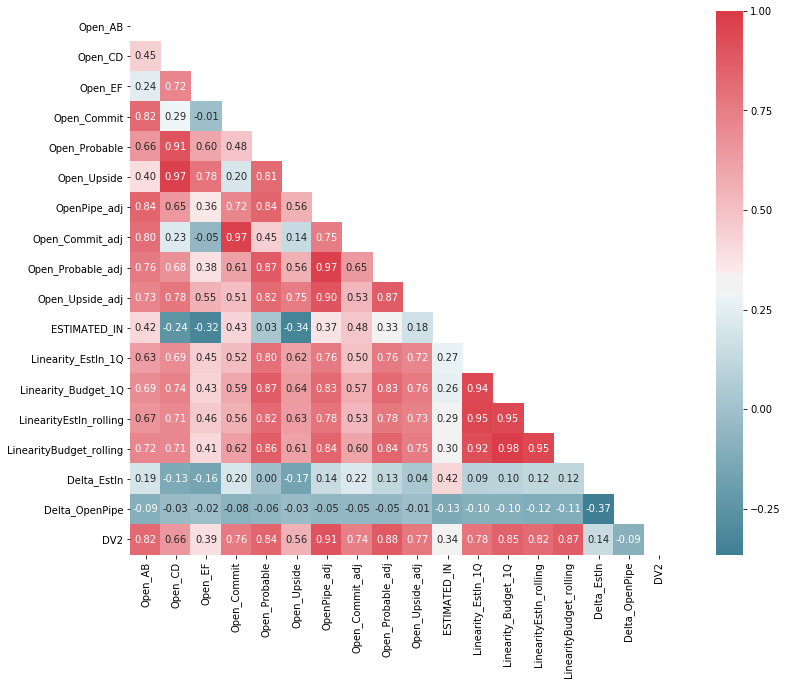

In [315]:
features = AnalyticalData.loc[: , 'Open_AB' : 'Delta_OpenPipe']
features = pd.concat([features, AnalyticalData['DV2']], axis=1)

plt.figure(figsize=(15, 10))  
colnm = features.columns.tolist()
mcorr = features[colnm].corr(method="spearman")  
mask = np.zeros_like(mcorr, dtype=np.bool)  
mask[np.triu_indices_from(mask)] = True 
cmap = sns.diverging_palette(220, 10, as_cmap=True)  
g = sns.heatmap(mcorr,  mask=mask, cmap=cmap, square=True, annot=True, fmt='0.2f')  
plt.show()

In [531]:
def train_model(model, param_grid, X=[], y=[], eval_set=[]):
        
    # setup grid search parameters
    gsearch = GridSearchCV(model, param_grid, verbose=0)

    gsearch.fit(X,y)

    # extract best model from the grid
    model = gsearch.best_estimator_        
    best_idx = gsearch.best_index_


    y_train_pred = model.predict(X)
    
    #joblib.dump(model, '/Users/i513088/Desktop/'+'count_'+str(model)[:20]+'.pkl')
    # print stats on model performance         
    print('----------------------')
    print(model)
    print('----------------------')
    print('Train MAPE:',np.mean(MAPE(y_train_pred, y)))
    
    return model


def model_predict(model, x_test,y_test):
    
    y_predict = model.predict(x_test)

    mape = np.mean(MAPE(y_predict, y_test))
    
    y_pred_model1[model] = pd.Series(y_predict)
    
    y_pred_model1[str(model)+'mape'] = pd.Series(MAPE(y_predict, y_test))
    
    y_pred_model1.to_csv('/Users/i513088/Desktop/y_pred_model1_count-Q5.csv')

    print('The model',model, 'test mape is:', mape)
    print('Finished!')

    return y_predict
    

In [532]:
y_pred_model1 = pd.DataFrame()


# Here I use the K-Fold validation set, but we can igore this step
X_train, X_val, Y_train, Y_val = train_test_split(train_x, train_y, test_size=0.15)

In [533]:
model_name = 'Linear'
model = linear_model.LinearRegression()
fit_intercept = [False]
param_grid = {'fit_intercept': fit_intercept}
LinearReg = train_model(model, param_grid=param_grid, X=X_train, y=Y_train, eval_set=[(X_val, Y_val)])
LinearReg_Pred = model_predict(LinearReg,test_x,test_y)
LinearReg_coef = LinearReg.coef_

'''
model_name = 'Lasso'
model = Lasso()
fit_intercept = [False]
alph_range = np.arange(0.1,6,0.25)
param_grid = {'alpha': alph_range, 'fit_intercept': fit_intercept}
LassoReg = train_model(model, param_grid=param_grid, X=X_train, y=Y_train, eval_set=[(X_val, Y_val)])
LassoReg_coef = LassoReg.coef_
LassoReg_Pred = model_predict(LassoReg,test_x,test_y)
'''


model_name ='ElasticNet'
model = ElasticNet()
param_grid = {'alpha': np.arange(0.1,6,0.25),
              'l1_ratio': np.arange(0.1,1.0,0.1),
              'max_iter':[100000]}
ElasticReg = train_model(model, param_grid=param_grid, X=X_train, y=Y_train, eval_set=[(X_val, Y_val)])
ElasticReg_coef = ElasticReg.coef_

ElasticReg_Pred = model_predict(ElasticReg,test_x, test_y)



model_name = 'GradientBoosting'
model = GradientBoostingRegressor()
param_grid = {'n_estimators':[150,250,350],
              'max_depth':[2,3,4,5],
              'min_samples_split':[5,6,7]}
GBM = train_model(model, param_grid=param_grid, X=X_train, y=Y_train, eval_set=[(X_val, Y_val)])
GBM_Pred = model_predict(GBM, test_x,test_y)


'''
model_name = 'XGB'
model = XGBRegressor()
param_grid = {'n_estimators':[100,200,300,400],
              'max_depth':[2,3,4,5],
             }
XGB = train_model(model, param_grid=param_grid, X=X_train, y=Y_train, eval_set=[(X_val, Y_val)])
XGB_Pred = model_predict(XGB,test_x,test_y)



model_name = 'RandomForest'
model = RandomForestRegressor()
param_grid = {'n_estimators':[100,150,200],
              'min_samples_split':[2,4,6]
             }
RF = train_model(model, param_grid=param_grid, X=X_train, y=Y_train, eval_set=[(X_val, Y_val)])

RF_Pred = model_predict(RF,test_x,test_y)
'''

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning:

You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning:

You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.



----------------------
LinearRegression(copy_X=True, fit_intercept=False, n_jobs=None,
         normalize=False)
----------------------
Train MAPE: 26.563688183660467
The model LinearRegression(copy_X=True, fit_intercept=False, n_jobs=None,
         normalize=False) test mape is: 33.604042882997796
Finished!


/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

/Users/i513088/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning:

Objective did not converge. You might want to increase the number of it

----------------------
ElasticNet(alpha=0.1, copy_X=True, fit_intercept=True, l1_ratio=0.1,
      max_iter=100000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False)
----------------------
Train MAPE: 37.55312604548863
The model ElasticNet(alpha=0.1, copy_X=True, fit_intercept=True, l1_ratio=0.1,
      max_iter=100000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False) test mape is: 60.096086882995955
Finished!
----------------------
GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=4, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=6, min_weight_fraction_leaf=0.0,
             n_estimators=350, n_iter_no_change=None, presort='auto',
          

"\nmodel_name = 'XGB'\nmodel = XGBRegressor()\nparam_grid = {'n_estimators':[100,200,300,400],\n              'max_depth':[2,3,4,5],\n             }\nXGB = train_model(model, param_grid=param_grid, X=X_train, y=Y_train, eval_set=[(X_val, Y_val)])\nXGB_Pred = model_predict(XGB,test_x,test_y)\n\n\n\nmodel_name = 'RandomForest'\nmodel = RandomForestRegressor()\nparam_grid = {'n_estimators':[100,150,200],\n              'min_samples_split':[2,4,6]\n             }\nRF = train_model(model, param_grid=param_grid, X=X_train, y=Y_train, eval_set=[(X_val, Y_val)])\n\nRF_Pred = model_predict(RF,test_x,test_y)\n"

### MLP

In [534]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense,Dropout
from keras.optimizers import RMSprop
from keras import optimizers


batch_size = 50
epochs = 600
input_shape=(9,)
    
kf = KFold(n_splits=4, random_state=None, shuffle=True)

# Building the MLP model

model = Sequential()

model.reset_states() 
model.add(Dense(256,activation='linear',input_shape=input_shape))
#model.add(Dense(128,activation='relu',input_shape=input_shape))
#model.add(Dense(128,activation='linear'))
model.add(Dense(64,activation='linear'))
model.add(Dense(32,activation='linear'))
model.add(Dense(1,activation='linear'))


model.compile(loss='mae', optimizer=optimizers.Adagrad(lr=0.15, epsilon=None, decay=0.01))

model.summary()

for train_index, test_index in kf.split(train_x):
    
    #print("TRAIN:", train_index, "TEST:", test_index)
    
    x_train, x_test = train_x.iloc[train_index], train_x.iloc[test_index]
    y_train, y_test = train_y.iloc[train_index], train_y.iloc[test_index]

    x_train = np.reshape(x_train,(len(x_train),9))
    x_test = np.reshape(x_test,(len(x_test),9))
    
    x_train = x_train.astype('float32')
    y_train = y_train.astype('float32')
    x_test = x_test.astype('float32')
    y_test = y_test.astype('float32')
    
    model.fit(x_train,y_train, batch_size=batch_size, epochs=epochs, verbose=0, validation_data=(x_test,y_test))



predicted_train = model.predict(train_x)
predicted_train = np.reshape(predicted_train, np.shape(train_y))
mape_train = np.mean(MAPE(train_y, predicted_train))


predicted_test = model.predict(test_x)
mlp_predicted_test = np.reshape(predicted_test, np.shape(test_y))
mape_test = np.mean(MAPE(mlp_predicted_test, test_y))


y_pred_model1['MLP'] = pd.Series(mlp_predicted_test)
    
y_pred_model1['MLP_mape'] = pd.Series(MAPE(mlp_predicted_test, test_y))
    
y_pred_model1.to_csv('/Users/i513088/Desktop/y_pred_model1_count-Q5.csv')
    
    
print('mae score_train:',score_train)
print('MAPE_train is: ', mape_train,'%')

print('mae score_test:',score_test)
print('MAPE_test is: ', mape_test,'%')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_65 (Dense)             (None, 256)               2560      
_________________________________________________________________
dense_66 (Dense)             (None, 64)                16448     
_________________________________________________________________
dense_67 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_68 (Dense)             (None, 1)                 33        
Total params: 21,121
Trainable params: 21,121
Non-trainable params: 0
_________________________________________________________________
mae score_train: 15254.357828987419
MAPE_train is:  inf %
mae score_test: 7930.166542658731
MAPE_test is:  22.527397514922615 %


/Users/i513088/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:49: RuntimeWarning:

divide by zero encountered in true_divide



### Following steps, just some process of achieved bootstrapping forecasting result, in order to get the final well-structured dataset. The code will be a bit repetitive.

In [551]:
q1 = pd.read_csv('/Users/i513088/Desktop/y_pred_model1_count-Q1.csv')
q2 = pd.read_csv('/Users/i513088/Desktop/y_pred_model1_count-Q2.csv')
q3 = pd.read_csv('/Users/i513088/Desktop/y_pred_model1_count-Q3.csv')
q4 = pd.read_csv('/Users/i513088/Desktop/y_pred_model1_count-Q4.csv')
q5 = pd.read_csv('/Users/i513088/Desktop/y_pred_model1_count-Q5.csv')

In [552]:
# we need to change the columns name

y_pred_q1 = pd.DataFrame()
y_pred_q2 = pd.DataFrame()
y_pred_q3 = pd.DataFrame()
y_pred_q4 = pd.DataFrame()
y_pred_q5 = pd.DataFrame()


y_pred_q1 = pd.DataFrame({'LinearReg':q1.iloc[:,1], 'LinearReg_Mape':q1.iloc[:,2], 
                    'ElasticNet':q1.iloc[:,3], 'ElasticNet_mape':q1.iloc[:,4],
                   'GBM':q1.iloc[:,5], 'GBM_mape':q1.iloc[:,6],
                   'MLP':q1.iloc[:,7], 'MLP_mape':q1.iloc[:,8],
                   })


y_pred_q2 = pd.DataFrame({'LinearReg':q2.iloc[:,1], 'LinearReg_Mape':q2.iloc[:,2], 
                    'ElasticNet':q2.iloc[:,3], 'ElasticNet_mape':q2.iloc[:,4],
                   'GBM':q2.iloc[:,5], 'GBM_mape':q2.iloc[:,6],
                   'MLP':q2.iloc[:,7], 'MLP_mape':q2.iloc[:,8],
                   })

y_pred_q3 = pd.DataFrame({'LinearReg':q3.iloc[:,1], 'LinearReg_Mape':q3.iloc[:,2], 
                    'ElasticNet':q3.iloc[:,3], 'ElasticNet_mape':q3.iloc[:,4],
                   'GBM':q3.iloc[:,5], 'GBM_mape':q3.iloc[:,6],
                   'MLP':q3.iloc[:,7], 'MLP_mape':q3.iloc[:,8],
                   })

y_pred_q4 = pd.DataFrame({'LinearReg':q4.iloc[:,1], 'LinearReg_Mape':q4.iloc[:,2], 
                    'ElasticNet':q4.iloc[:,3], 'ElasticNet_mape':q4.iloc[:,4],
                   'GBM':q4.iloc[:,5], 'GBM_mape':q4.iloc[:,6],
                   'MLP':q4.iloc[:,7], 'MLP_mape':q4.iloc[:,8],
                   })

y_pred_q5 = pd.DataFrame({'LinearReg':q5.iloc[:,1], 'LinearReg_Mape':q5.iloc[:,2], 
                    'ElasticNet':q5.iloc[:,3], 'ElasticNet_mape':q5.iloc[:,4],
                   'GBM':q5.iloc[:,5], 'GBM_mape':q5.iloc[:,6],
                   'MLP':q5.iloc[:,7], 'MLP_mape':q5.iloc[:,8],
                   })


y_pred_q1['QuarterIndex']=1
y_pred_q2['QuarterIndex']=2
y_pred_q3['QuarterIndex']=3
y_pred_q4['QuarterIndex']=4
y_pred_q5['QuarterIndex']=5



y_pred_q1.to_csv('/Users/i513088/Desktop/Final-model/y_pred_model1_count-Q1.csv')
y_pred_q2.to_csv('/Users/i513088/Desktop/Final-model/y_pred_model1_count-Q2.csv')
y_pred_q3.to_csv('/Users/i513088/Desktop/Final-model/y_pred_model1_count-Q3.csv')
y_pred_q4.to_csv('/Users/i513088/Desktop/Final-model/y_pred_model1_count-Q4.csv')
y_pred_q5.to_csv('/Users/i513088/Desktop/Final-model/y_pred_model1_count-Q5.csv')



In [554]:
y_pred_model1_q5 = pd.read_csv('/Users/i513088/Desktop/Final-model/y_pred_model1_count-Q5.csv')
y_pred_model1_q5

,Unnamed: 0,LinearReg,LinearReg_Mape,ElasticNet,ElasticNet_mape,GBM,GBM_mape,MLP,MLP_mape,QuarterIndex
0,0,47189.308034,5.218630,44315.683431,0.927413,35470.087123,26.096879,47833.79300,6.495659,5
1,1,47241.353070,4.090628,44241.397849,2.412870,36843.831546,22.975498,47050.58200,3.701754,5
2,2,47393.362161,3.058497,44300.307127,3.709975,36730.047663,25.085156,46245.38300,0.652055,5
3,3,47469.871908,2.350881,44416.172434,4.362689,37342.860109,24.130588,46425.60500,0.154427,5
4,4,47450.635385,2.974993,44395.627140,3.701615,36894.498344,24.785495,46460.39500,0.907035,5
5,5,47838.937620,3.270168,44784.040823,3.328157,37049.121111,24.900464,47044.60500,1.636918,5
6,6,49234.518963,1.712345,46215.689772,4.707848,37998.822662,27.349878,48738.80000,0.712669,5
7,7,49993.980512,3.384989,46984.487973,2.803483,37932.489669,27.335934,49470.95000,2.363527,5
8,8,49698.534900,5.397103,46683.458352,0.712876,37720.181783,24.644822,49128.90200,4.300216,5
9,9,50990.370947,11.305794,48073.484523,5.924221,37690.494380,19.991806,50471.75400,10.394426,5


### Following, add the limitation on the forecasting result and get the daliy MAPE

In [790]:
holdout = AnalyticalData[(AnalyticalData.QuarterIndex == 5)].reset_index()
holdout = holdout.sort_values(['GLOBAL_01_CODE', 'SnapDate']).reset_index()

In [791]:
y_pred = pd.read_csv('/Users/i513088/Desktop/Final-model/y_pred_model1_count-Q1.csv')


In [792]:
holdout.loc[holdout.OpenPipe_adj <= 0, 'OpenPipe_adj'] = 0
holdout['MAPE_WeightedPipe'] = abs(holdout['OpenPipe_adj'] - holdout['DV2']) / holdout['DV2']


holdout = pd.concat([holdout, pd.DataFrame(y_pred.LinearReg, columns = ["LinearReg"])], axis=1, sort=False)
holdout.loc[holdout.LinearReg <= 0, 'LinearReg'] = 0
holdout['MAPE_LR'] = abs(holdout['LinearReg'] - holdout['DV2']) / holdout['DV2']


holdout = pd.concat([holdout, pd.DataFrame(y_pred.ElasticNet, columns = ["ElasticNet"])], axis=1, sort=False)
holdout.loc[holdout.ElasticNet <= 0, 'ElasticNet'] = 0
holdout['MAPE_ElasticNet'] = abs(holdout['ElasticNet'] - holdout['DV2']) / holdout['DV2']


holdout = pd.concat([holdout, pd.DataFrame(y_pred.GBM, columns = ["GBM"])], axis=1, sort=False)
holdout.loc[holdout.GBM <= 0, 'GBM'] = 0
holdout['MAPE_GBM'] = abs(holdout['GBM'] - holdout['DV2']) / holdout['DV2']


holdout = pd.concat([holdout, pd.DataFrame(y_pred.MLP, columns = ["MLP"])], axis=1, sort=False)
holdout.loc[holdout.MLP <= 0, 'MLP'] = 0
holdout['MAPE_MLP'] = abs(holdout['MLP'] - holdout['DV2']) / holdout['DV2']

### applying upper and lower boundaries to the forecast

In [793]:
holdout.loc[holdout.LinearReg > holdout.UpperBoundary, 
                   'LinearReg'] = holdout.UpperBoundary

holdout.loc[holdout.LinearReg < holdout.LowerBoundary, 
                   'LinearReg'] = holdout.LowerBoundary


holdout.loc[holdout.ElasticNet > holdout.UpperBoundary, 
                   'ElasticNet'] = holdout.UpperBoundary

holdout.loc[holdout.ElasticNet < holdout.LowerBoundary, 
                   'ElasticNet'] = holdout.LowerBoundary


holdout.loc[holdout.OpenPipe_adj > holdout.UpperBoundary, 
                   'OpenPipe_adj'] = holdout.UpperBoundary

holdout.loc[holdout.OpenPipe_adj < holdout.LowerBoundary, 
                   'OpenPipe_adj'] = holdout.LowerBoundary

holdout.loc[holdout.GBM > holdout.UpperBoundary, 
                   'GBM'] = holdout.UpperBoundary

holdout.loc[holdout.GBM < holdout.LowerBoundary, 
                   'GBM'] = holdout.LowerBoundary

'''
holdout.loc[holdout.LassoReg > holdout.UpperBoundary, 
                   'LassoReg'] = holdout.UpperBoundary

holdout.loc[holdout.LassoReg < holdout.LowerBoundary, 
                   'LassoReg'] = holdout.LowerBoundary


holdout.loc[holdout.XGB > holdout.UpperBoundary, 
                   'XGB'] = holdout.UpperBoundary

holdout.loc[holdout.XGB < holdout.LowerBoundary, 
                   'XGB'] = holdout.LowerBoundary

holdout.loc[holdout.RF > holdout.UpperBoundary, 
                   'RF'] = holdout.UpperBoundary

holdout.loc[holdout.RF < holdout.LowerBoundary, 
                   'RF'] = holdout.LowerBoundary
'''

holdout.loc[holdout.MLP > holdout.UpperBoundary, 
                   'MLP'] = holdout.UpperBoundary

holdout.loc[holdout.MLP < holdout.LowerBoundary, 
                   'MLP'] = holdout.LowerBoundary

In [ ]:
holdout.to_csv("/Users/i513088/Desktop/Final-model/model1_count_Q1.csv")

### After we get the all bootstrapping forecasting result from Q1-Q5, we can combine them all, and then we can get the final model2 result for each one regression model.

In [874]:
q1=pd.read_csv("/Users/i513088/Desktop/Final-model/model1_bootstrap/model1_count_Q1.csv")
q2=pd.read_csv("/Users/i513088/Desktop/Final-model/model1_bootstrap/model1_count_Q2.csv")
q3=pd.read_csv("/Users/i513088/Desktop/Final-model/model1_bootstrap/model1_count_Q3.csv")
q4=pd.read_csv("/Users/i513088/Desktop/Final-model/model1_bootstrap/model1_count_Q4.csv")
q5=pd.read_csv("/Users/i513088/Desktop/Final-model/model1_bootstrap/model1_count_Q5.csv")

#model1.read_csv("/Users/i513088/Desktop/Final-model/model1_count_all.csv")

model1 = pd.concat([q1,q2,q3,q4,q5]).reset_index(drop=True)

#model1.to_csv('/Users/i513088/Desktop/Final-model/model1_bootstrap/model1_count_all.csv')

# this 'model1' dataset contains the result of model1 by different regression model: MLP, or LR, EN, GBM, etc) 

"sums.loc[sums.CLOSING_QUARTER_ACTUAL=='2018-Q1', 'QuarterIndex'] = 1\nsums.loc[sums.CLOSING_QUARTER_ACTUAL=='2018-Q2', 'QuarterIndex'] = 2\nsums.loc[sums.CLOSING_QUARTER_ACTUAL=='2018-Q3', 'QuarterIndex'] = 3\nsums.loc[sums.CLOSING_QUARTER_ACTUAL=='2018-Q4', 'QuarterIndex'] = 4\nsums.loc[sums.CLOSING_QUARTER_ACTUAL=='2019-Q1', 'QuarterIndex'] = 5\n"

# Plots / Validations

## Weighted Pipe

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]  [ (1,3) x3,y3 ]
[ (2,1) x4,y4 ]  [ (2,2) x5,y5 ]  [ (2,3) x6,y6 ]
[ (3,1) x7,y7 ]  [ (3,2) x8,y8 ]  [ (3,3) x9,y9 ]



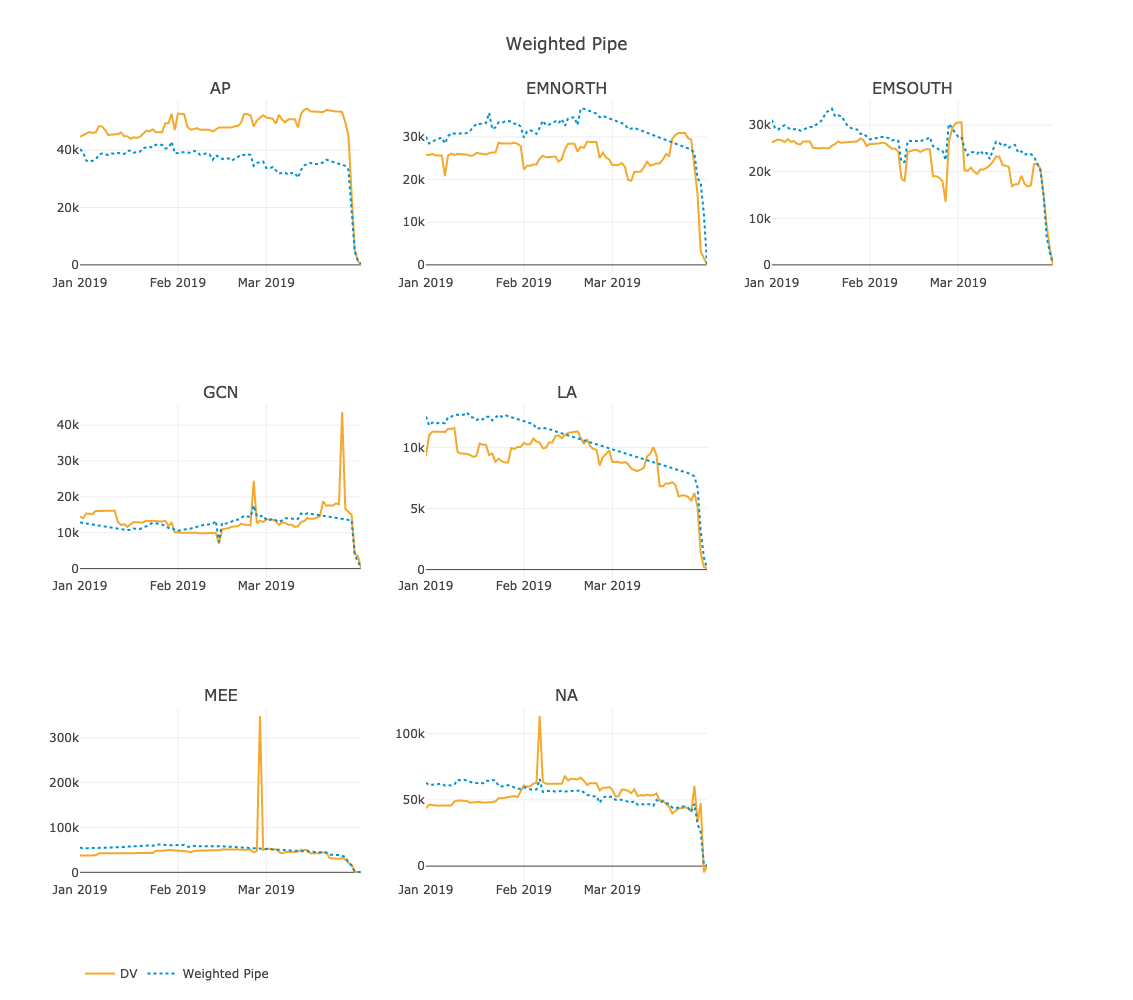

In [211]:
from plotly import tools
import plotly.offline as py
import plotly.graph_objs as go

trace1_AP = go.Scatter(
    x = holdout.loc[holdout.GLOBAL_01_CODE == "AP", ['SnapDate']].values.squeeze(),
    y = holdout.loc[holdout.GLOBAL_01_CODE == "AP", ['DV2']].values.squeeze(),
    line = dict(
        color = ('rgb(244, 169, 45)'),
        width = 2),
    name = 'DV'
)
trace2_AP = go.Scatter(
    x = holdout.loc[holdout.GLOBAL_01_CODE == "AP", ['SnapDate']].values.squeeze(),
    y = holdout.loc[holdout.GLOBAL_01_CODE == "AP", ['OpenPipe_adj']].values.squeeze(),
    line = dict(
        color = ('rgb(0, 146, 208)'),
        width = 2,
        dash = 'dot'),
    name = 'Weighted Pipe',
)
trace1_EN = go.Scatter(
    x = holdout.loc[holdout.GLOBAL_01_CODE == "EMNORTH", ['SnapDate']].values.squeeze(),
    y = holdout.loc[holdout.GLOBAL_01_CODE == "EMNORTH", ['DV2']].values.squeeze(),
    line = dict(
        color = ('rgb(244, 169, 45)'),
        width = 2),
    name = 'DV',
    showlegend=False
)
trace2_EN = go.Scatter(
    x = holdout.loc[holdout.GLOBAL_01_CODE == "EMNORTH", ['SnapDate']].values.squeeze(),
    y = holdout.loc[holdout.GLOBAL_01_CODE == "EMNORTH", ['OpenPipe_adj']].values.squeeze(),
    line = dict(
        color = ('rgb(0, 146, 208)'),
        width = 2,
        dash = 'dot'),
    name = 'Weighted Pipe',
    showlegend=False
)
trace1_ES = go.Scatter(
    x = holdout.loc[holdout.GLOBAL_01_CODE == "EMSOUTH", ['SnapDate']].values.squeeze(),
    y = holdout.loc[holdout.GLOBAL_01_CODE == "EMSOUTH", ['DV2']].values.squeeze(),
    line = dict(
        color = ('rgb(244, 169, 45)'),
        width = 2),
    name = 'DV',
    showlegend=False
)
trace2_ES = go.Scatter(
    x = holdout.loc[holdout.GLOBAL_01_CODE == "EMSOUTH", ['SnapDate']].values.squeeze(),
    y = holdout.loc[holdout.GLOBAL_01_CODE == "EMSOUTH", ['OpenPipe_adj']].values.squeeze(),
    line = dict(
        color = ('rgb(0, 146, 208)'),
        width = 2,
        dash = 'dot'),
    name = 'Weighted Pipe',
    showlegend=False
)
trace1_GC = go.Scatter(
    x = holdout.loc[holdout.GLOBAL_01_CODE == "GCN", ['SnapDate']].values.squeeze(),
    y = holdout.loc[holdout.GLOBAL_01_CODE == "GCN", ['DV2']].values.squeeze(),
    line = dict(
        color = ('rgb(244, 169, 45)'),
        width = 2),
    name = 'DV',
    showlegend=False
)
trace2_GC = go.Scatter(
    x = holdout.loc[holdout.GLOBAL_01_CODE == "GCN", ['SnapDate']].values.squeeze(),
    y = holdout.loc[holdout.GLOBAL_01_CODE == "GCN", ['OpenPipe_adj']].values.squeeze(),
       line = dict(
        color = ('rgb(0, 146, 208)'),
        width = 2,
        dash = 'dot'),
    name = 'Weighted Pipe',
    showlegend=False
)
trace1_LA = go.Scatter(
    x = holdout.loc[holdout.GLOBAL_01_CODE == "LA", ['SnapDate']].values.squeeze(),
    y = holdout.loc[holdout.GLOBAL_01_CODE == "LA", ['DV2']].values.squeeze(),
    line = dict(
        color = ('rgb(244, 169, 45)'),
        width = 2),
    name = 'DV',
    showlegend=False
)
trace2_LA = go.Scatter(
    x = holdout.loc[holdout.GLOBAL_01_CODE == "LA", ['SnapDate']].values.squeeze(),
    y = holdout.loc[holdout.GLOBAL_01_CODE == "LA", ['OpenPipe_adj']].values.squeeze(),
    line = dict(
        color = ('rgb(0, 146, 208)'),
        width = 2,
        dash = 'dot'),
    name = 'Weighted Pipe',
    showlegend=False
)
trace1_ME = go.Scatter(
    x = holdout.loc[holdout.GLOBAL_01_CODE == "MEE", ['SnapDate']].values.squeeze(),
    y = holdout.loc[holdout.GLOBAL_01_CODE == "MEE", ['DV2']].values.squeeze(),
    line = dict(
        color = ('rgb(244, 169, 45)'),
        width = 2),
    name = 'DV',
    showlegend=False
)
trace2_ME = go.Scatter(
    x = holdout.loc[holdout.GLOBAL_01_CODE == "MEE", ['SnapDate']].values.squeeze(),
    y = holdout.loc[holdout.GLOBAL_01_CODE == "MEE", ['OpenPipe_adj']].values.squeeze(),
    line = dict(
        color = ('rgb(0, 146, 208)'),
        width = 2,
        dash = 'dot'),
    name = 'Weighted Pipe',
    showlegend=False
)
trace1_NA = go.Scatter(
    x = holdout.loc[holdout.GLOBAL_01_CODE == "NOAM", ['SnapDate']].values.squeeze(),
    y = holdout.loc[holdout.GLOBAL_01_CODE == "NOAM", ['DV2']].values.squeeze(),
    line = dict(
        color = ('rgb(244, 169, 45)'),
        width = 2),
    name = 'DV',
    showlegend=False
)
trace2_NA = go.Scatter(
    x = holdout.loc[holdout.GLOBAL_01_CODE == "NOAM", ['SnapDate']].values.squeeze(),
    y = holdout.loc[holdout.GLOBAL_01_CODE == "NOAM", ['OpenPipe_adj']].values.squeeze(),
    line = dict(
        color = ('rgb(0, 146, 208)'),
        width = 2,
        dash = 'dot'),
    name = 'Weighted Pipe',
    showlegend=False
)

fig = tools.make_subplots(rows=3, cols=3, subplot_titles=('AP', 'EMNORTH', 'EMSOUTH', 
                                                          'GCN', 'LA', '',
                                                         'MEE', 'NA'))
fig.append_trace(trace1_AP, 1, 1)
fig.append_trace(trace2_AP, 1, 1)
fig.append_trace(trace1_EN, 1, 2)
fig.append_trace(trace2_EN, 1, 2)
fig.append_trace(trace1_ES, 1, 3)
fig.append_trace(trace2_ES, 1, 3)
fig.append_trace(trace1_GC, 2, 1)
fig.append_trace(trace2_GC, 2, 1)
fig.append_trace(trace1_LA, 2, 2)
fig.append_trace(trace2_LA, 2, 2)
fig.append_trace(trace1_ME, 3, 1)
fig.append_trace(trace2_ME, 3, 1)
fig.append_trace(trace1_NA, 3, 2)
fig.append_trace(trace2_NA, 3, 2)

fig['layout'].update(height=1000, width=1800, 
                     legend=dict(orientation="h"),
                    title = 'Weighted Pipe')

py.iplot(fig, filename='make-subplots-multiple-with-titles')


In [2514]:
from pivottablejs import pivot_ui

pivot_ui(holdout.loc[(holdout.DayInQuarter_asc > 15) & (holdout.DayInQuarter_asc < 75),
                                    ['LinearRegr', 'GLOBAL_01_CODE', 'DayInQuarter_asc', 'MAPE_WeightedPipe']], 
        vals=['MAPE_WeightedPipe'],
        aggregatorName='Average',
        rows=['GLOBAL_01_CODE'])

### Linear regression

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]  [ (1,3) x3,y3 ]
[ (2,1) x4,y4 ]  [ (2,2) x5,y5 ]  [ (2,3) x6,y6 ]
[ (3,1) x7,y7 ]  [ (3,2) x8,y8 ]  [ (3,3) x9,y9 ]



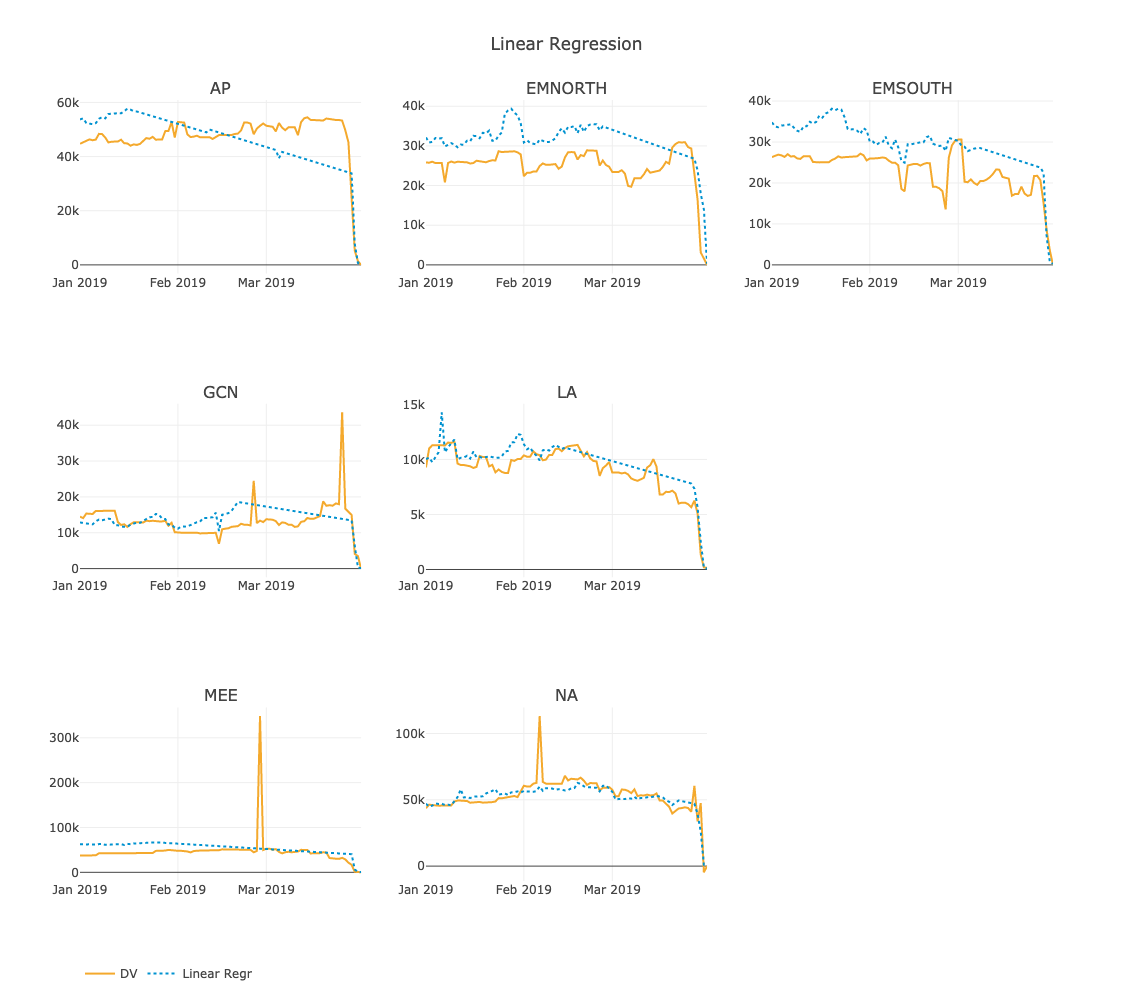

In [2515]:
from plotly import tools
import plotly.offline as py
import plotly.graph_objs as go

trace1_AP = go.Scatter(
    x = holdout.loc[holdout.GLOBAL_01_CODE == "AP", ['SnapDate']].values.squeeze(),
    y = holdout.loc[holdout.GLOBAL_01_CODE == "AP", ['DV2']].values.squeeze(),
    line = dict(
        color = ('rgb(244, 169, 45)'),
        width = 2),
    name = 'DV'
)
trace2_AP = go.Scatter(
    x = holdout.loc[holdout.GLOBAL_01_CODE == "AP", ['SnapDate']].values.squeeze(),
    y = holdout.loc[holdout.GLOBAL_01_CODE == "AP", ['LinearRegr']].values.squeeze(),
    line = dict(
        color = ('rgb(0, 146, 208)'),
        width = 2,
        dash = 'dot'),
    name = 'Linear Regr'
)
trace1_EN = go.Scatter(
    x = holdout.loc[holdout.GLOBAL_01_CODE == "EMNORTH", ['SnapDate']].values.squeeze(),
    y = holdout.loc[holdout.GLOBAL_01_CODE == "EMNORTH", ['DV2']].values.squeeze(),
    line = dict(
        color = ('rgb(244, 169, 45)'),
        width = 2),
    name = 'DV',
    showlegend=False
)
trace2_EN = go.Scatter(
    x = holdout.loc[holdout.GLOBAL_01_CODE == "EMNORTH", ['SnapDate']].values.squeeze(),
    y = holdout.loc[holdout.GLOBAL_01_CODE == "EMNORTH", ['LinearRegr']].values.squeeze(),
    line = dict(
        color = ('rgb(0, 146, 208)'),
        width = 2,
        dash = 'dot'),
    name = 'Linear Regr',
    showlegend=False
)
trace1_ES = go.Scatter(
    x = holdout.loc[holdout.GLOBAL_01_CODE == "EMSOUTH", ['SnapDate']].values.squeeze(),
    y = holdout.loc[holdout.GLOBAL_01_CODE == "EMSOUTH", ['DV2']].values.squeeze(),
    line = dict(
        color = ('rgb(244, 169, 45)'),
        width = 2),
    name = 'DV',
    showlegend=False
)
trace2_ES = go.Scatter(
    x = holdout.loc[holdout.GLOBAL_01_CODE == "EMSOUTH", ['SnapDate']].values.squeeze(),
    y = holdout.loc[holdout.GLOBAL_01_CODE == "EMSOUTH", ['LinearRegr']].values.squeeze(),
    line = dict(
        color = ('rgb(0, 146, 208)'),
        width = 2,
        dash = 'dot'),
    name = 'Linear Regr',
    showlegend=False
)
trace1_GC = go.Scatter(
    x = holdout.loc[holdout.GLOBAL_01_CODE == "GCN", ['SnapDate']].values.squeeze(),
    y = holdout.loc[holdout.GLOBAL_01_CODE == "GCN", ['DV2']].values.squeeze(),
    line = dict(
        color = ('rgb(244, 169, 45)'),
        width = 2),
    name = 'DV',
    showlegend=False
)
trace2_GC = go.Scatter(
    x = holdout.loc[holdout.GLOBAL_01_CODE == "GCN", ['SnapDate']].values.squeeze(),
    y = holdout.loc[holdout.GLOBAL_01_CODE == "GCN", ['LinearRegr']].values.squeeze(),
       line = dict(
        color = ('rgb(0, 146, 208)'),
        width = 2,
        dash = 'dot'),
    name = 'Linear Regr',
    showlegend=False
)
trace1_LA = go.Scatter(
    x = holdout.loc[holdout.GLOBAL_01_CODE == "LA", ['SnapDate']].values.squeeze(),
    y = holdout.loc[holdout.GLOBAL_01_CODE == "LA", ['DV2']].values.squeeze(),
    line = dict(
        color = ('rgb(244, 169, 45)'),
        width = 2),
    name = 'DV',
    showlegend=False
)
trace2_LA = go.Scatter(
    x = holdout.loc[holdout.GLOBAL_01_CODE == "LA", ['SnapDate']].values.squeeze(),
    y = holdout.loc[holdout.GLOBAL_01_CODE == "LA", ['LinearRegr']].values.squeeze(),
    line = dict(
        color = ('rgb(0, 146, 208)'),
        width = 2,
        dash = 'dot'),
    name = 'Linear Regr',
    showlegend=False
)
trace1_ME = go.Scatter(
    x = holdout.loc[holdout.GLOBAL_01_CODE == "MEE", ['SnapDate']].values.squeeze(),
    y = holdout.loc[holdout.GLOBAL_01_CODE == "MEE", ['DV2']].values.squeeze(),
    line = dict(
        color = ('rgb(244, 169, 45)'),
        width = 2),
    name = 'DV',
    showlegend=False
)
trace2_ME = go.Scatter(
    x = holdout.loc[holdout.GLOBAL_01_CODE == "MEE", ['SnapDate']].values.squeeze(),
    y = holdout.loc[holdout.GLOBAL_01_CODE == "MEE", ['LinearRegr']].values.squeeze(),
    line = dict(
        color = ('rgb(0, 146, 208)'),
        width = 2,
        dash = 'dot'),
    name = 'Linear Regr',
    showlegend=False
)
trace1_NA = go.Scatter(
    x = holdout.loc[holdout.GLOBAL_01_CODE == "NOAM", ['SnapDate']].values.squeeze(),
    y = holdout.loc[holdout.GLOBAL_01_CODE == "NOAM", ['DV2']].values.squeeze(),
    line = dict(
        color = ('rgb(244, 169, 45)'),
        width = 2),
    name = 'DV',
    showlegend=False
)
trace2_NA = go.Scatter(
    x = holdout.loc[holdout.GLOBAL_01_CODE == "NOAM", ['SnapDate']].values.squeeze(),
    y = holdout.loc[holdout.GLOBAL_01_CODE == "NOAM", ['LinearRegr']].values.squeeze(),
    line = dict(
        color = ('rgb(0, 146, 208)'),
        width = 2,
        dash = 'dot'),
    name = 'Linear Regr',
    showlegend=False
)

fig = tools.make_subplots(rows=3, cols=3, subplot_titles=('AP', 'EMNORTH', 'EMSOUTH', 
                                                          'GCN', 'LA', '',
                                                         'MEE', 'NA'))
fig.append_trace(trace1_AP, 1, 1)
fig.append_trace(trace2_AP, 1, 1)
fig.append_trace(trace1_EN, 1, 2)
fig.append_trace(trace2_EN, 1, 2)
fig.append_trace(trace1_ES, 1, 3)
fig.append_trace(trace2_ES, 1, 3)
fig.append_trace(trace1_GC, 2, 1)
fig.append_trace(trace2_GC, 2, 1)
fig.append_trace(trace1_LA, 2, 2)
fig.append_trace(trace2_LA, 2, 2)
fig.append_trace(trace1_ME, 3, 1)
fig.append_trace(trace2_ME, 3, 1)
fig.append_trace(trace1_NA, 3, 2)
fig.append_trace(trace2_NA, 3, 2)

fig['layout'].update(height=1000, width=1800, 
                     legend=dict(orientation="h"),
                    title = 'Linear Regression')

py.iplot(fig, filename='make-subplots-multiple-with-titles')

In [2516]:
#import sys
#!{sys.executable} -m pip install pivottablejs 

from pivottablejs import pivot_ui

pivot_ui(holdout.loc[(holdout.DayInQuarter_asc > 15) & (holdout.DayInQuarter_asc < 75),
                                    ['LinearRegr', 'GLOBAL_01_CODE', 'SnapDate', 'MAPE_LR']], 
        vals=['MAPE_LR'],
        aggregatorName='Average',
        rows=['GLOBAL_01_CODE'])

### Lasso regression

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]  [ (1,3) x3,y3 ]
[ (2,1) x4,y4 ]  [ (2,2) x5,y5 ]  [ (2,3) x6,y6 ]
[ (3,1) x7,y7 ]  [ (3,2) x8,y8 ]  [ (3,3) x9,y9 ]



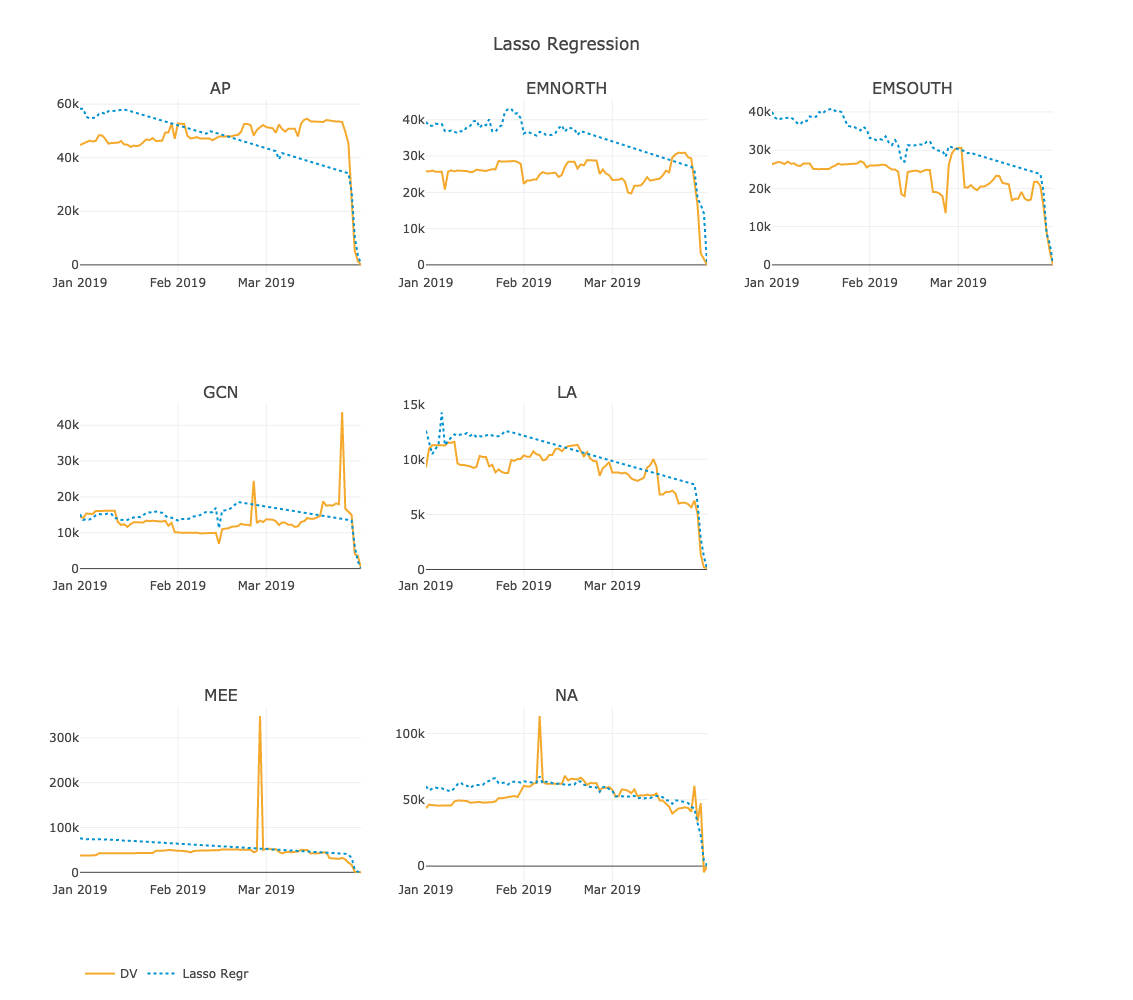

In [2517]:
from plotly import tools
import plotly.offline as py
import plotly.graph_objs as go

trace1_AP = go.Scatter(
    x = holdout.loc[holdout.GLOBAL_01_CODE == "AP", ['SnapDate']].values.squeeze(),
    y = holdout.loc[holdout.GLOBAL_01_CODE == "AP", ['DV2']].values.squeeze(),
    line = dict(
        color = ('rgb(244, 169, 45)'),
        width = 2),
    name = 'DV'
)
trace2_AP = go.Scatter(
    x = holdout.loc[holdout.GLOBAL_01_CODE == "AP", ['SnapDate']].values.squeeze(),
    y = holdout.loc[holdout.GLOBAL_01_CODE == "AP", ['LassoRegr']].values.squeeze(),
    line = dict(
        color = ('rgb(0, 146, 208)'),
        width = 2,
        dash = 'dot'),
    name = 'Lasso Regr'
)
trace1_EN = go.Scatter(
    x = holdout.loc[holdout.GLOBAL_01_CODE == "EMNORTH", ['SnapDate']].values.squeeze(),
    y = holdout.loc[holdout.GLOBAL_01_CODE == "EMNORTH", ['DV2']].values.squeeze(),
    line = dict(
        color = ('rgb(244, 169, 45)'),
        width = 2),
    name = 'DV',
    showlegend=False
)
trace2_EN = go.Scatter(
    x = holdout.loc[holdout.GLOBAL_01_CODE == "EMNORTH", ['SnapDate']].values.squeeze(),
    y = holdout.loc[holdout.GLOBAL_01_CODE == "EMNORTH", ['LassoRegr']].values.squeeze(),
    line = dict(
        color = ('rgb(0, 146, 208)'),
        width = 2,
        dash = 'dot'),
    name = 'Lasso Regr',
    showlegend=False
)
trace1_ES = go.Scatter(
    x = holdout.loc[holdout.GLOBAL_01_CODE == "EMSOUTH", ['SnapDate']].values.squeeze(),
    y = holdout.loc[holdout.GLOBAL_01_CODE == "EMSOUTH", ['DV2']].values.squeeze(),
    line = dict(
        color = ('rgb(244, 169, 45)'),
        width = 2),
    name = 'DV',
    showlegend=False
)
trace2_ES = go.Scatter(
    x = holdout.loc[holdout.GLOBAL_01_CODE == "EMSOUTH", ['SnapDate']].values.squeeze(),
    y = holdout.loc[holdout.GLOBAL_01_CODE == "EMSOUTH", ['LassoRegr']].values.squeeze(),
    line = dict(
        color = ('rgb(0, 146, 208)'),
        width = 2,
        dash = 'dot'),
    name = 'Lasso Regr',
    showlegend=False
)
trace1_GC = go.Scatter(
    x = holdout.loc[holdout.GLOBAL_01_CODE == "GCN", ['SnapDate']].values.squeeze(),
    y = holdout.loc[holdout.GLOBAL_01_CODE == "GCN", ['DV2']].values.squeeze(),
    line = dict(
        color = ('rgb(244, 169, 45)'),
        width = 2),
    name = 'DV',
    showlegend=False
)
trace2_GC = go.Scatter(
    x = holdout.loc[holdout.GLOBAL_01_CODE == "GCN", ['SnapDate']].values.squeeze(),
    y = holdout.loc[holdout.GLOBAL_01_CODE == "GCN", ['LassoRegr']].values.squeeze(),
       line = dict(
        color = ('rgb(0, 146, 208)'),
        width = 2,
        dash = 'dot'),
    name = 'Lasso Regr',
    showlegend=False
)
trace1_LA = go.Scatter(
    x = holdout.loc[holdout.GLOBAL_01_CODE == "LA", ['SnapDate']].values.squeeze(),
    y = holdout.loc[holdout.GLOBAL_01_CODE == "LA", ['DV2']].values.squeeze(),
    line = dict(
        color = ('rgb(244, 169, 45)'),
        width = 2),
    name = 'DV',
    showlegend=False
)
trace2_LA = go.Scatter(
    x = holdout.loc[holdout.GLOBAL_01_CODE == "LA", ['SnapDate']].values.squeeze(),
    y = holdout.loc[holdout.GLOBAL_01_CODE == "LA", ['LassoRegr']].values.squeeze(),
    line = dict(
        color = ('rgb(0, 146, 208)'),
        width = 2,
        dash = 'dot'),
    name = 'Lasso Regr',
    showlegend=False
)
trace1_ME = go.Scatter(
    x = holdout.loc[holdout.GLOBAL_01_CODE == "MEE", ['SnapDate']].values.squeeze(),
    y = holdout.loc[holdout.GLOBAL_01_CODE == "MEE", ['DV2']].values.squeeze(),
    line = dict(
        color = ('rgb(244, 169, 45)'),
        width = 2),
    name = 'DV',
    showlegend=False
)
trace2_ME = go.Scatter(
    x = holdout.loc[holdout.GLOBAL_01_CODE == "MEE", ['SnapDate']].values.squeeze(),
    y = holdout.loc[holdout.GLOBAL_01_CODE == "MEE", ['LassoRegr']].values.squeeze(),
    line = dict(
        color = ('rgb(0, 146, 208)'),
        width = 2,
        dash = 'dot'),
    name = 'Lasso Regr',
    showlegend=False
)
trace1_NA = go.Scatter(
    x = holdout.loc[holdout.GLOBAL_01_CODE == "NOAM", ['SnapDate']].values.squeeze(),
    y = holdout.loc[holdout.GLOBAL_01_CODE == "NOAM", ['DV2']].values.squeeze(),
    line = dict(
        color = ('rgb(244, 169, 45)'),
        width = 2),
    name = 'DV',
    showlegend=False
)
trace2_NA = go.Scatter(
    x = holdout.loc[holdout.GLOBAL_01_CODE == "NOAM", ['SnapDate']].values.squeeze(),
    y = holdout.loc[holdout.GLOBAL_01_CODE == "NOAM", ['LassoRegr']].values.squeeze(),
    line = dict(
        color = ('rgb(0, 146, 208)'),
        width = 2,
        dash = 'dot'),
    name = 'Lasso Regr',
    showlegend=False
)

fig = tools.make_subplots(rows=3, cols=3, subplot_titles=('AP', 'EMNORTH', 'EMSOUTH', 
                                                          'GCN', 'LA', '',
                                                         'MEE', 'NA'))
fig.append_trace(trace1_AP, 1, 1)
fig.append_trace(trace2_AP, 1, 1)
fig.append_trace(trace1_EN, 1, 2)
fig.append_trace(trace2_EN, 1, 2)
fig.append_trace(trace1_ES, 1, 3)
fig.append_trace(trace2_ES, 1, 3)
fig.append_trace(trace1_GC, 2, 1)
fig.append_trace(trace2_GC, 2, 1)
fig.append_trace(trace1_LA, 2, 2)
fig.append_trace(trace2_LA, 2, 2)
fig.append_trace(trace1_ME, 3, 1)
fig.append_trace(trace2_ME, 3, 1)
fig.append_trace(trace1_NA, 3, 2)
fig.append_trace(trace2_NA, 3, 2)

fig['layout'].update(height=1000, width=1800, 
                     legend=dict(orientation="h"),
                    title = 'Lasso Regression')

py.iplot(fig, filename='make-subplots-multiple-with-titles')

## <font color='red'>We can compare the 7 different models' mape here, and we could say that WeightedPipe is the best and most stable method for our green part forecasting!!<font>

# structure Holdout sampe

In [2519]:
holdout.loc[holdout.GLOBAL_01_CODE == "AP", ['DV2', 'LinearRegr',  'BUDGET', 'OpenPipe', 'Open_AB', 'Open_CD', 'Open_EF', 'DayInQuarter_asc']].head(40)

,DV2,LinearRegr,BUDGET,OpenPipe,Open_AB,Open_CD,Open_EF,DayInQuarter_asc
0,44726.672863,53717.254432,104904.04286,356182.330515,23925.821340,281643.455100,50613.054075,1
1,45308.885259,54115.330255,104904.04286,343974.624955,23798.876383,274552.346249,45623.402323,2
2,45943.837479,52392.741064,104904.04286,304825.525117,23854.706293,245859.442155,35111.376669,3
3,46353.911725,52051.011689,104904.04286,294700.391218,24186.551149,237284.905040,33228.935029,4
4,46038.982335,51961.903549,104904.04286,291968.639851,23768.047482,235664.632663,32535.959706,5
5,46274.524005,52348.378902,104904.04286,291191.368073,23803.905839,234749.913758,32637.548476,6
6,48391.454275,53968.213095,104904.04286,291640.593404,27236.565282,232936.045894,31467.982228,7
7,48301.689987,54580.038027,104904.04286,289604.829494,27245.995375,230725.573930,31633.260189,8
8,47016.253577,54107.413532,104904.04286,287669.567347,27186.983420,228819.426868,31663.157059,9
9,45225.504870,55740.690582,104904.04286,285082.228031,26147.823260,228277.359458,30657.045313,10


In [2520]:
holdout.head(2)

,level_0,index,SnapDate,DayInQuarter,DayInQuarter_asc,GLOBAL_01_CODE,CLOSING_QUARTER_ACTUAL,QuarterIndex,BUDGET,DV2,...,Delta_EstIn,Delta_OpenPipe,Ratio_DVBud,UpperBoundary,LowerBoundary,LassoRegr,MAPE_Lasso,LinearRegr,MAPE_LR,MAPE_WeightedPipe
0,0,2555,2019-01-01,90,1,AP,2019-Q1,5,104904.04286,44726.672863,...,33.591131,-12207.70556,0.426358,62942.425716,31471.212858,58255.93639,0.302488,53717.254432,0.201012,0.143464
1,7,2562,2019-01-02,89,2,AP,2019-Q1,5,104904.04286,45308.885259,...,33.591131,-12207.70556,0.431908,62592.745573,31121.532715,58297.07349,0.286659,54115.330255,0.194365,0.114472


## Stepwise linear regression

In [2521]:
import statsmodels.api as sm

def backward_regression(X, y,
                           threshold_out,
                           verbose=False):
    included=list(X.columns)
    while True:
        changed=False
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.idxmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

result = backward_regression(train.loc[: , 'Open_AB' : 'Delta_OpenPipe'], train['DV2'], 0.1)

print('resulting features:')
result

resulting features:


/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: FutureWarning:

Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.



['Open_AB',
 'Open_CD',
 'Open_EF',
 'Open_Commit',
 'Open_Probable',
 'Open_Upside',
 'OpenPipe_adj',
 'Open_Commit_adj',
 'Open_Probable_adj',
 'Open_Upside_adj',
 'ESTIMATED_IN',
 'Linearity_EstIn_1Q',
 'Linearity_Budget_1Q',
 'LinearityEstIn_rolling',
 'Delta_OpenPipe']

In [2522]:
def forward_regression(X, y,
                       threshold_in,
                       verbose=False):
    initial_list = []
    included = list(initial_list)
    while True:
        changed=False
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        if not changed:
            break

    return included

result = forward_regression(train.loc[: , 'Open_AB' : 'Delta_OpenPipe'], train['DV2'], 0.1)

print('resulting features:')
result

resulting features:


['Linearity_Budget_1Q',
 'OpenPipe_adj',
 'Open_Probable',
 'Open_AB',
 'Open_Probable_adj',
 'Open_EF',
 'Linearity_EstIn_1Q',
 'Open_Commit_adj',
 'Open_Upside_adj',
 'Open_Commit',
 'ESTIMATED_IN',
 'Open_CD',
 'Open_Upside',
 'Delta_OpenPipe',
 'LinearityEstIn_rolling']

# export to csv

In [48]:
list(holdout)
holdout.head()


,level_0,index,Unnamed: 0,SnapDate,DayInQuarter,DayInQuarter_asc,GLOBAL_01_CODE,CLOSING_QUARTER_ACTUAL,QuarterIndex,BUDGET,...,MAPE_Lasso,LinearReg,MAPE_LR,MAPE_WeightedPipe,GBM,MAPE_GBM,XGB,MAPE_XGB,RF,MAPE_RF
0,0,2555,2555,2019-01-01,90,1,AP,2019-Q1,5,104904.04286,...,0.214908,54339.136846,0.214916,0.143464,50974.282808,0.139684,36713.927298,0.179149,40670.11,0.090697
1,7,2562,2562,2019-01-02,89,2,AP,2019-Q1,5,104904.04286,...,0.207609,54715.752980,0.207616,0.114472,51211.475891,0.130274,36502.355328,0.194367,40435.58,0.107557
2,14,2569,2569,2019-01-03,88,3,AP,2019-Q1,5,104904.04286,...,0.151583,52908.546823,0.151592,0.002431,49229.379368,0.071512,39034.895669,0.150378,37437.42,0.185148
3,21,2576,2576,2019-01-04,87,4,AP,2019-Q1,5,104904.04286,...,0.133688,52551.315260,0.133698,0.015177,48902.604158,0.054983,36827.492116,0.205515,36729.15,0.207636
4,28,2583,2583,2019-01-05,86,5,AP,2019-Q1,5,104904.04286,...,0.140018,52485.686535,0.140027,0.003746,48853.012519,0.061123,34578.957640,0.248920,35713.96,0.224267


In [794]:
#holdout.to_csv("~/OneDrive - SAP SE/1 Projects/160629_PipelineForecasting/GIT/Licenses/Rebuild1811/model1.csv")
holdout.to_csv("/Users/i513088/Desktop/Final-model/model1_count_Q1.csv")